# Coefficient Estimation for NEWT

At this point, we have established that, with the available periods-of-record, a stationary SCHEMA works quite well, though some sort of dynamism is likely to help with longer-range applications.  Still, the emphasis is on short-term and S2S forecasting, so long-range efficiency isn't critical (and, more to the point, can be returned to later).  Now, let's look at coefficient estimation, where dynamic fitting is likely to be more important.

Here's the basic idea.  We want to be able to run a watershed model without pre-feeding years of data, but we also want to benefit from data on atmospheric conditions.  How should we proceed?

- Develop one fit for model coefficients based only on static surface conditions (XYZ, slope and aspect, land cover/LAI, drainage area)
- Develop a separate fit for model coefficients based only on dynamic conditions (mean precipitation, temperature, and humidity; land cover/LAI again; soil moisture; aridity)
- Tune two "drift rates": climate drift (rate of convergence from static-only to climate-only; possibly with a final equilibrium weighting), and recency weight (weighting of climate over time, controlling speed of correction for climate shifts)

For early reporting, I will prototype this with a single model accounting for all data.  Then, I'll build a static-only watershed model generator and a climate-drift model modification engine for the final implementation.

Data requirements:

- Model fits (have)
- Weather data (have)
- Land cover/LAI (have)
- Some kind of groundwater
- Topography summaries (have)
- Calculate aspect and slope (not avail for most watersheds, so need to calculate)
- Aridity or NDVI or something for dry years (need)

TODO: add aspect and a seasonality index.

In [1]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
from sklearn.decomposition import PCA
import pygam  # https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html
from pygam import LinearGAM, s, te, l, f
from NEWT import Watershed, kfold, perf_summary, statics, analysis

In [2]:
def idfix(data):
    data = data[data["id"].apply(lambda x: x.startswith("USGS"))]
    data["id"] = data["id"].apply(lambda x: x.split("_")[1])
    return data

In [3]:
# sillymod: use one generic model.  Otherwise, fit each model to itself.
def dummy_modbuilder(data, sillymod):
    data = data.groupby("date")[["temperature", "tmax", "vp"]].mean().assign(date = lambda x: x.index)
    def runner(ws):
        try:
            if sillymod:
                return Watershed.from_data(data).run_series(ws)
            else:
                return Watershed.from_data(ws).run_series(ws)
        except Exception as e:
            print(e)
    return runner

In [4]:
data = pd.read_csv("AllData.csv", dtype={"id": "str"}).rename(columns={"temperature.mean": "temperature"})
data = data[(data["temperature"] > -0.1) & (data["temperature"] < 50)]  # basic QA
data["date"] = pd.to_datetime(data["date"])
data["day"] = data["date"].dt.day_of_year
gsamp = pd.read_csv("GageSample.csv",
                   dtype={"id": "str"})
lcov = idfix(pd.read_csv("LandCover.csv"))
area = idfix(pd.read_csv("Area.csv"))
topo = idfix(pd.read_csv("Topography.csv"))
data = data.merge(lcov, on="id").merge(area, on="id").merge(topo, on="id").merge(gsamp[["id", "lat", "lon"]], on="id")
data

id       date  temperature       prcp       srad  swe  \
0        13011820 2020-03-31     0.100000  17.110126  248.76216  NaN   
1        13011820 2020-04-01     0.100000   7.202532  403.38873  NaN   
2        13011820 2020-04-02     0.100000   2.167848  600.86993  NaN   
3        13011820 2020-04-03     0.100000   2.987468  509.44165  NaN   
4        13011820 2020-04-04     0.100000   6.021518  465.97583  NaN   
...           ...        ...          ...        ...        ...  ...   
2976628  03047000 2022-12-27     0.540625   0.000000  268.23563  NaN   
2976629  03047000 2022-12-28     0.407292   0.000000  279.93356  NaN   
2976630  03047000 2022-12-29     0.428125   0.000000  290.53482  NaN   
2976631  03047000 2022-12-30     0.661458   0.000000  285.53320  NaN   
2976632  03047000 2022-12-31     0.743750   3.910029  144.37915  NaN   

              tmax  tmin         vp  day  ...  ice_snow          area  \
0         1.795443   NaN  444.26370   91  ...       0.0  7.993837e+07   
1         0.030759   NaN  270.94354   92  ...       0.0  7.993837e+07   
2        -3.442405   NaN  132.77936   93  ...       0.0  7.993837e+07   
3        -2.238481   NaN  138.35303   94  ...       0.0  7.993837e+07   
4         3.509114   NaN  284.43704   95  ...       0.0  7.993837e+07   
...            ...   ...        ...  ...  ...       ...           ...   
2976628  -2.151775   NaN  207.79785  361  ...       0.0  6.878668e+08   
2976629   5.509683   NaN  310.02664  362  ...       0.0  6.878668e+08   
2976630  13.100331   NaN  354.31638  363  ...       0.0  6.878668e+08   
2976631  17.568270   NaN  512.88240  364  ...       0.0  6.878668e+08   
2976632  12.166826   NaN  832.86690  365  ...       0.0  6.878668e+08   

              elev     elev_min    elev_std     slope  asp_north  asp_east  \
0        2868.2670  2549.556152  130.430969  0.000243   0.003187  0.002841   
1        2868.2670  2549.556152  130.430969  0.000243   0.003187  0.002841   
2        2868.2670  2549.556152  130.430969  0.000243   0.003187  0.002841   
3        2868.2670  2549.556152  130.430969  0.000243   0.003187  0.002841   
4        2868.2670  2549.556152  130.430969  0.000243   0.003187  0.002841   
...            ...          ...         ...       ...        ...       ...   
2976628   457.4157   257.871948  133.578278  0.000671   0.004324  0.003170   
2976629   457.4157   257.871948  133.578278  0.000671   0.004324  0.003170   
2976630   457.4157   257.871948  133.578278  0.000671   0.004324  0.003170   
2976631   457.4157   257.871948  133.578278  0.000671   0.004324  0.003170   
2976632   457.4157   257.871948  133.578278  0.000671   0.004324  0.003170   

               lat         lon  
0        43.807111 -110.178722  
1        43.807111 -110.178722  
2        43.807111 -110.178722  
3        43.807111 -110.178722  
4        43.807111 -110.178722  
...            ...         ...  
2976628  40.458889  -79.449444  
2976629  40.458889  -79.449444  
2976630  40.458889  -79.449444  
2976631  40.458889  -79.449444  
2976632  40.458889  -79.449444  

[2976633 rows x 28 columns]

In [5]:
data.drop(columns="date").describe()

temperature          prcp          srad            swe          tmax  \
count  2.976633e+06  2.976633e+06  2.976633e+06  574269.000000  2.976633e+06   
mean   1.311872e+01  3.429751e+00  3.278384e+02      17.590640  1.698680e+01   
std    7.738649e+00  8.027406e+00  1.310998e+02      49.510846  1.057882e+01   
min   -1.000000e-01  0.000000e+00  1.599158e+01       0.000000 -2.844553e+01   
25%    6.788542e+00  0.000000e+00  2.277412e+02       0.000000  8.819924e+00   
50%    1.262917e+01  0.000000e+00  3.288709e+02       0.000000  1.796277e+01   
75%    1.922083e+01  3.164689e+00  4.296845e+02       7.130459  2.576481e+01   
max    4.310000e+01  2.717640e+02  8.285261e+02     750.342160  4.495986e+01   

               tmin            vp           day         water     developed  \
count  1.426173e+06  2.976633e+06  2.976633e+06  2.976633e+06  2.976633e+06   
mean   5.175722e+00  9.865759e+02  1.875569e+02  1.266080e-02  1.480316e-01   
std    9.322134e+00  6.467537e+02  1.036473e+02  2.056525e-02  2.194467e-01   
min   -3.778280e+01  1.937390e+01  1.000000e+00  0.000000e+00  0.000000e+00   
25%   -1.098755e+00  5.106492e+02  1.000000e+02  1.829815e-03  1.888149e-02   
50%    5.201742e+00  7.763886e+02  1.900000e+02  5.872330e-03  6.005536e-02   
75%    1.203221e+01  1.331654e+03  2.770000e+02  1.543504e-02  1.492019e-01   
max    2.819078e+01  3.693103e+03  3.650000e+02  2.316803e-01  9.849686e-01   

       ...      ice_snow          area          elev      elev_min  \
count  ...  2.976633e+06  2.976633e+06  2.976633e+06  2.976633e+06   
mean   ...  5.786279e-04  5.397796e+09  8.036510e+02  4.392206e+02   
std    ...  3.468099e-03  1.153623e+10  7.745481e+02  5.596526e+02   
min    ...  0.000000e+00  8.833804e+05  1.203066e+01 -8.578022e+01   
25%    ...  0.000000e+00  1.247376e+08  2.667484e+02  1.071924e+02   
50%    ...  0.000000e+00  6.558886e+08  4.574157e+02  2.420944e+02   
75%    ...  0.000000e+00  4.034122e+09  1.132412e+03  4.318893e+02   
max    ...  6.341746e-02  9.451191e+10  3.601852e+03  2.880272e+03   

           elev_std         slope     asp_north      asp_east           lat  \
count  2.976633e+06  2.976633e+06  2.976633e+06  2.976633e+06  2.976633e+06   
mean   1.945884e+02  1.880241e-03  7.338711e-03 -1.527016e-03  3.991275e+01   
std    2.217749e+02  2.523759e-03  1.016865e-02  1.514247e-02  4.613852e+00   
min    1.231675e+00  4.762368e-05 -1.538242e-02 -2.824883e-01  2.697500e+01   
25%    3.074977e+01  4.483381e-04  3.460877e-03 -2.773193e-03  3.730994e+01   
50%    1.143489e+02  9.428893e-04  5.018477e-03  2.168743e-03  4.002733e+01   
75%    2.930310e+02  2.337958e-03  8.378913e-03  3.922721e-03  4.325262e+01   
max    1.427199e+03  3.008171e-02  2.041745e-01  1.524249e-02  4.899881e+01   

                lon  
count  2.976633e+06  
mean  -9.568542e+01  
std    1.750425e+01  
min   -1.243930e+02  
25%   -1.120959e+02  
50%   -8.861419e+01  
75%   -8.047256e+01  
max   -6.780389e+01  

[8 rows x 26 columns]

## A Silly Kfold Test

First we need to test the cross-validation setup, so we have a dummy model to test it with.  One option is to use a model that's just trained on everything.  The other option is to use a model that's trained on each watershed to predict itself.

In [5]:
silly = kfold(data, lambda x: dummy_modbuilder(x, True), output="results/Silly.csv")
cheat = kfold(data, lambda x: dummy_modbuilder(x, False), output="results/Cheat.csv")

In [6]:
silly.groupby("id").apply(perf_summary, include_groups=False).median()

R2         0.927358
RMSE       2.889678
NSE        0.810347
Pbias      2.989468
Bias       0.369906
MaxMiss    1.845938
dtype: float64

## Prepare Coefficients

Since the kfold testing seems to be working, let's prepare model coefficients.  To recap, we need to provide seasonality coefficients, tmax and vp sensitivities, and tmax and vp dailies (for static/spin-up).  We can also set up dynamic and yearly modification engines, and will eventually separate estimators into static (at start) and climate/dynamic (through a climate modification engine), but that can come later.

A brief test was run and subsequently deleted to establish that simple sinusoid (annual-period, variable-phase sine) does a solid job capturing vp and tmax annual cycles (median R2 0.95 and 0.92, respectively), and therefore those coefficients are suitable here.

In [6]:
coefs = data.groupby("id").apply(lambda x: (
    pd.concat([
        Watershed.from_data(x).coefs_to_df().drop(columns=["R2", "RMSE"]),
        statics.fit_simple_daily(x, "tmax", True)
    ], axis=1)
) if len(x[["day", "temperature"]].dropna()["day"].unique()) >= 181 else None, include_groups=False)
coefs.index = coefs.index.get_level_values("id")
# Try normalizing
coefs["Amplitude"] = coefs["Amplitude"] / coefs["Intercept"]
coefs["SpringSummer"] = coefs["SpringSummer"] / coefs["Intercept"]
coefs["FallWinter"] = coefs["FallWinter"] / coefs["Intercept"]
coefs

Intercept  Amplitude  FallDay  WinterDay  SpringDay  \
id                                                                     
01010000          6.788488   2.108179    312.0       20.0      120.0   
01011000          8.502618   1.395171    322.0       27.0      120.0   
01018035          9.134936   1.306385    316.0       28.0      120.0   
01038000         10.871231   1.143689    319.0       27.0      169.0   
010642505         8.232986   1.123864    321.0       26.0      122.0   
...                    ...        ...      ...        ...        ...   
385903107210800   7.163091   1.292561    300.0       87.0      143.0   
394220106431500   6.965011   1.056319    324.0       84.0      156.0   
402114105350101   4.352286   1.686245    301.0       88.0      153.0   
404417108524900   9.623788   0.836247    330.0       75.0      157.0   
453004122510301  13.095366   0.549814    330.0       85.0      158.0   

                 SummerDay  SpringSummer  FallWinter   at_coef  \
id                                                               
01010000             239.0      0.111298    0.189004  0.778675   
01011000             204.0      0.282564    0.315668  0.604260   
01018035             206.0      0.201471    0.273593  0.639960   
01038000             200.0      0.082753    0.180850  0.468732   
010642505            233.0      0.214564    0.125174  0.415023   
...                    ...           ...         ...       ...   
385903107210800      201.0      0.290881    0.196800  0.474400   
394220106431500      237.0      0.405431    0.284142  0.320790   
402114105350101      237.0      0.573277    0.226162  0.404336   
404417108524900      204.0      0.188917    0.098705  0.371651   
453004122510301      205.0      0.028795    0.133585  0.666378   

                 threshold_act_min  threshold_coef_min  threshold_act_cutoff  \
id                                                                             
01010000                        -6           -1.827897                    -2   
01011000                        -1            0.031658                     5   
01018035                         0            0.126304                     3   
01038000                         0            0.113039                     4   
010642505                        0            0.162370                    15   
...                            ...                 ...                   ...   
385903107210800                  1           -0.019589                    11   
394220106431500                  0            0.083988                     3   
402114105350101                 -1           -0.007609                     2   
404417108524900                 -1           -1.000000                    -1   
453004122510301                 -1           -1.000000                    -1   

                 threshold_coef_max  intercept      ksin       kcos  
id                                                                   
01010000                   0.695855  10.183701 -4.827292 -13.373083  
01011000                   0.737392  10.182508 -5.544706 -14.000452  
01018035                   0.830579  11.897104 -5.285002 -13.442177  
01038000                   0.726634  12.411499 -5.377854 -12.851322  
010642505                  0.708612  10.084860 -5.104671 -12.878405  
...                             ...        ...       ...        ...  
385903107210800            0.545654  11.893447 -4.284127 -11.356781  
394220106431500            0.491630   9.466164 -3.972916 -10.774711  
402114105350101            0.486141   6.876817 -4.462743 -11.078878  
404417108524900            0.382719  16.928690 -4.684969 -13.954363  
453004122510301            0.675966  17.051518 -3.277676  -9.346154  

[923 rows x 16 columns]

In [7]:
coefs.describe()

Intercept   Amplitude     FallDay   WinterDay   SpringDay   SummerDay  \
count  923.000000  923.000000  923.000000  923.000000  923.000000  923.000000   
mean    12.743631    0.754094  326.722644   66.830444  153.699892  217.706392   
std      3.997808    0.319091   15.554292   32.644609   21.664216   17.314854   
min      3.085846    0.017450  300.000000    1.000000  120.000000  200.000000   
25%      9.905912    0.529393  317.000000   33.000000  134.000000  200.000000   
50%     12.521213    0.743901  327.000000   84.000000  155.000000  212.000000   
75%     14.904495    0.933679  333.000000   90.000000  176.000000  238.000000   
max     30.215404    3.417889  365.000000  110.000000  180.000000  240.000000   

       SpringSummer  FallWinter     at_coef  threshold_act_min  \
count    923.000000  923.000000  923.000000         923.000000   
mean       0.080411    0.119069    0.483304           1.484290   
std        0.124638    0.090588    0.203633           3.525938   
min       -0.235308   -0.213584   -0.197273          -6.000000   
25%        0.004909    0.069414    0.336572          -1.000000   
50%        0.036025    0.109052    0.506855           0.000000   
75%        0.115862    0.152190    0.644258           2.000000   
max        1.250888    0.598671    1.081874          18.000000   

       threshold_coef_min  threshold_act_cutoff  threshold_coef_max  \
count          923.000000            923.000000          923.000000   
mean            -0.182794              6.512459            0.570545   
std              0.628211              7.805152            0.307260   
min             -1.827897             -2.000000           -0.504395   
25%             -1.000000             -1.000000            0.390839   
50%              0.084437              4.000000            0.588209   
75%              0.309307             11.000000            0.748224   
max              1.060632             28.000000            3.463163   

        intercept        ksin        kcos  
count  923.000000  923.000000  923.000000  
mean    16.474342   -4.004920  -11.306945  
std      4.640388    0.890071    2.092663  
min      5.487426   -7.626287  -17.774793  
25%     13.121350   -4.580016  -12.568578  
50%     15.968952   -4.106887  -11.618910  
75%     19.304432   -3.448866   -9.773110  
max     29.365311   -1.362203   -2.724602

General observations:

- Minimum temperature (for threshold) can be computed from seasonality, so doesn't need to be fitted.
- There are non-trivial intercorrelations in seasonality.

Linear results:

- Air temperature coefficient correlates surprisingly well with Intercept, Amplitude, and WinterDay.
- Starting point of the threshold-coefficient doesn't correlate well with anything, but we may be able to get away with assuming that it's ~40% of the maximum.
- 50% of mean stream temperature is explained by mean air temperature alone.
- Threshold cutoff doesn't correlate too well with much, but it does correlate with minimum seasonal temperature and maximum coefficient, which together explain ~80% of its variance.  So probably we should just predict maximum and then calculate the rest under fixed assumptions.
- Maximum sensitivity correlates moderately with Amplitude, but not much else.  But that, we can predict using site data.

Nonlinear correlations:

- Minimum coefficient correlates much better with maximum coefficient; it may be possible to make a halfway-decent nonlinear guess (R2 ~60%).
- Cutoff, likewise, correlates well with the minimum coordinates.  Unclear how independent that is, but we could make a decent guess.
- A fair chunk of max sensitivity is predictable from Amplitude.
- Fully 80% of Intercept is explained by mean air temperature in a nonlinear fashion.

In [8]:
coefs.corr()

Intercept  Amplitude   FallDay  WinterDay  SpringDay  \
Intercept              1.000000  -0.578387  0.165611   0.393293   0.376205   
Amplitude             -0.578387   1.000000 -0.469026  -0.051740  -0.295596   
FallDay                0.165611  -0.469026  1.000000  -0.146691   0.120523   
WinterDay              0.393293  -0.051740 -0.146691   1.000000   0.414915   
SpringDay              0.376205  -0.295596  0.120523   0.414915   1.000000   
SummerDay              0.126225  -0.242478  0.351551  -0.203976   0.164063   
SpringSummer          -0.565676   0.364648 -0.090278  -0.345110  -0.204404   
FallWinter            -0.335574   0.579196 -0.507802   0.015039  -0.166628   
at_coef                0.453878   0.097315 -0.356604   0.534808   0.251445   
threshold_act_min      0.443211  -0.309124  0.079144   0.145529   0.121615   
threshold_coef_min     0.017057   0.239667 -0.151169   0.104918  -0.066185   
threshold_act_cutoff   0.226414   0.001020 -0.078723   0.179884  -0.018332   
threshold_coef_max     0.254924   0.222703 -0.354228   0.360087   0.062265   
intercept              0.908908  -0.644730  0.237549   0.401774   0.433821   
ksin                   0.623068  -0.616453  0.245685   0.160168   0.425125   
kcos                   0.408245  -0.649725  0.275955   0.051061   0.301437   

                      SummerDay  SpringSummer  FallWinter   at_coef  \
Intercept              0.126225     -0.565676   -0.335574  0.453878   
Amplitude             -0.242478      0.364648    0.579196  0.097315   
FallDay                0.351551     -0.090278   -0.507802 -0.356604   
WinterDay             -0.203976     -0.345110    0.015039  0.534808   
SpringDay              0.164063     -0.204404   -0.166628  0.251445   
SummerDay              1.000000      0.126110   -0.423997 -0.272048   
SpringSummer           0.126110      1.000000    0.290222 -0.450513   
FallWinter            -0.423997      0.290222    1.000000  0.181727   
at_coef               -0.272048     -0.450513    0.181727  1.000000   
threshold_act_min      0.077497     -0.185251   -0.143092  0.099450   
threshold_coef_min    -0.189925     -0.135766    0.234296  0.223747   
threshold_act_cutoff  -0.083698     -0.174236    0.019151  0.239511   
threshold_coef_max    -0.275067     -0.313243    0.243383  0.745373   
intercept              0.130611     -0.577705   -0.365852  0.419977   
ksin                   0.235614     -0.193207   -0.287882  0.203815   
kcos                   0.269272     -0.006865   -0.348350 -0.016181   

                      threshold_act_min  threshold_coef_min  \
Intercept                      0.443211            0.017057   
Amplitude                     -0.309124            0.239667   
FallDay                        0.079144           -0.151169   
WinterDay                      0.145529            0.104918   
SpringDay                      0.121615           -0.066185   
SummerDay                      0.077497           -0.189925   
SpringSummer                  -0.185251           -0.135766   
FallWinter                    -0.143092            0.234296   
at_coef                        0.099450            0.223747   
threshold_act_min              1.000000            0.559510   
threshold_coef_min             0.559510            1.000000   
threshold_act_cutoff           0.682549            0.747317   
threshold_coef_max             0.071916            0.307294   
intercept                      0.420409           -0.036290   
ksin                           0.237866           -0.196701   
kcos                           0.322899           -0.255158   

                      threshold_act_cutoff  threshold_coef_max  intercept  \
Intercept                         0.226414            0.254924   0.908908   
Amplitude                         0.001020            0.222703  -0.644730   
FallDay                          -0.078723           -0.354228   0.237549   
WinterDay                         0.179884            0.360087   0.401774   
SpringDay                     

<Axes: xlabel='intercept', ylabel='Intercept'>

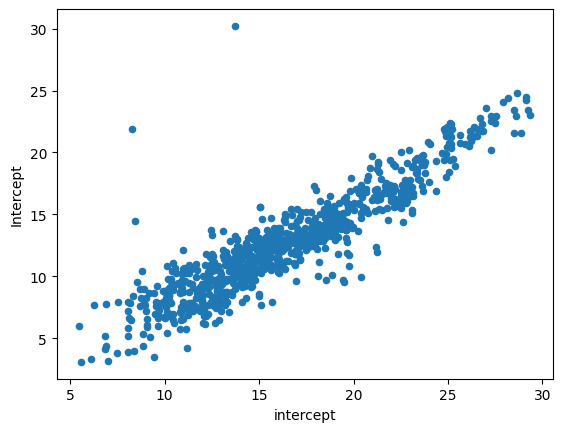

In [9]:
coefs[coefs["Intercept"] > 0].plot.scatter(x="intercept", y="Intercept")

## PCA

In [73]:
co_norm = (coefs - coefs.mean()) / coefs.std()
co_norm.iloc[:, :10]

Intercept  Amplitude   FallDay  WinterDay  SpringDay  \
id                                                                        
01010000        0  -0.943126   1.020460 -0.239062  -1.207480  -1.574790   
01011000        0  -0.874865   1.046572 -0.303112  -1.222831  -1.574790   
01018035        0  -0.762433   1.146347 -0.367163  -1.192130  -1.574790   
01038000        0  -0.379418   1.302420 -0.495264  -1.222831   0.691799   
010642505       0  -0.941962   0.135945 -0.367163  -1.253531  -1.482276   
...                      ...        ...       ...        ...        ...   
385903107210800 0  -1.170092   0.138135 -1.712223   0.619173  -0.510881   
394220106431500 0  -1.212328  -0.559231 -0.175011   0.527073   0.090459   
402114105350101 0  -1.769430  -0.565924 -1.648173   0.649873  -0.048312   
404417108524900 0  -0.645406  -0.305953  0.209292   0.250773   0.136716   
453004122510301 0   0.094826  -0.616907  0.209292   0.557773   0.182973   

                   SummerDay  SpringSummer  FallWinter   at_coef   vp_coef  
id                                                                          
01010000        0   1.057523      1.185340    2.035952 -0.495313  0.335223  
01011000        0  -0.790702      1.723365    1.467359 -0.592296  0.137413  
01018035        0  -0.675188      1.043375    1.274206 -0.305630  0.431983  
01038000        0  -1.021730      0.162987    0.618842 -0.218354  0.366795  
010642505       0   0.884252      0.976034   -0.397956 -0.516314  0.444743  
...                      ...           ...         ...       ...       ...  
385903107210800 0  -0.963973      1.273442    0.014126  0.466665 -0.691027  
394220106431500 0   1.115280      1.967705    0.632957 -0.344901 -0.445304  
402114105350101 0   1.115280      1.659354   -0.448210  0.022142 -0.365879  
404417108524900 0  -0.790702      1.024420   -0.485600 -0.072189 -0.398778  
453004122510301 0  -0.732945     -0.327122    0.383290  1.132283  0.391498  

[923 rows x 10 columns]

There are some nontrivial cross-correlations, so let's see what the principal component axes look like.  Let's limit it to stream properties (10 variables).

In [74]:
pca = PCA()
fit = pca.fit(co_norm.iloc[:, :10])
evr = fit.explained_variance_ratio_
print(evr)
print(np.cumsum(evr))

[0.28635317 0.19484294 0.16747634 0.07725998 0.07444256 0.05951356
 0.0512307  0.0416597  0.03223543 0.01498563]
[0.28635317 0.48119611 0.64867245 0.72593242 0.80037498 0.85988854
 0.91111925 0.95277894 0.98501437 1.        ]


Compared to 10 coefficients, we can capture ~95% of the variance with 8 components.  6 components capture 86%.  Doesn't really seem worth pursuing.

<Axes: >

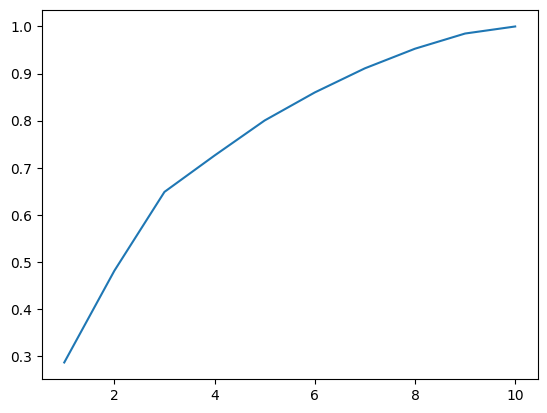

In [75]:
sns.lineplot(x=np.arange(1, len(evr)+1), y=np.cumsum(evr))

## Coefficient Correlations

### Geography

What's predictable from linear XYZ (plus squared longitude, which gives access to "coasts vs middle")?

In [98]:
coef_xyz = coefs.merge(data[["lat", "lon", "elev", "id"]].groupby("id").mean(), on="id").assign(lon2 = lambda x: (x["lon"] - x["lon"].mean())**2)
coef_xyz

Intercept  Amplitude  FallDay  WinterDay  SpringDay  \
id                                                                     
01010000          8.227527  11.664508    323.0       27.5      120.0   
01011000          8.547659  11.735706    322.0       27.0      120.0   
01018035          9.074948  12.007753    321.0       28.0      120.0   
01038000         10.871231  12.433309    319.0       27.0      169.0   
010642505         8.232986   9.252760    321.0       26.0      122.0   
...                    ...        ...      ...        ...        ...   
385903107210800   7.163091   9.258731    300.0       87.0      143.0   
394220106431500   6.965011   7.357272    324.0       84.0      156.0   
402114105350101   4.352286   7.339022    301.0       88.0      153.0   
404417108524900   9.623788   8.047868    330.0       75.0      157.0   
453004122510301  13.095366   7.200009    330.0       85.0      158.0   

                 SummerDay  SpringSummer  FallWinter   at_coef   vp_coef  \
id                                                                         
01010000             236.0      1.989669    3.269881  0.275727  0.001378   
01011000             204.0      2.563314    2.746746  0.255334  0.001096   
01018035             206.0      1.838306    2.569034  0.315614  0.001516   
01038000             200.0      0.899632    1.966065  0.333966  0.001423   
010642505            233.0      1.766506    1.030557  0.271311  0.001534   
...                    ...           ...         ...       ...       ...   
385903107210800      201.0      2.083604    1.409694  0.478011 -0.000085   
394220106431500      237.0      2.823831    1.979052  0.307356  0.000265   
402114105350101      237.0      2.495065    0.984321  0.384537  0.000378   
404417108524900      204.0      1.818095    0.949920  0.364702  0.000331   
453004122510301      205.0      0.377075    1.749345  0.617977  0.001458   

                 intercept_tm   ksin_tm    kcos_tm  intercept_vp     ksin_vp  \
id                                                                             
01010000             8.787829 -6.067253 -15.167896    693.766616 -266.789732   
01011000             9.763696 -5.932321 -14.604735    699.838476 -263.185827   
01018035            11.344458 -5.606314 -14.288229    766.456060 -289.078520   
01038000            12.411499 -5.377854 -12.851322    880.149454 -319.869872   
010642505           10.084860 -5.104671 -12.878405    718.774950 -241.243771   
...                       ...       ...        ...           ...         ...   
385903107210800     11.893447 -4.284127 -11.356781    574.381380 -190.504921   
394220106431500      9.466164 -3.972916 -10.774711    516.589866 -135.047240   
402114105350101      6.876817 -4.462743 -11.078878    476.261802 -147.476692   
404417108524900     16.928690 -4.684969 -13.954363    474.951314 -156.727685   
453004122510301     17.051518 -3.277676  -9.346154    911.928914  -23.288029   

                    kcos_vp        lat         lon        elev        lon2  
id                                                                          
01010000        -570.140506  46.700556  -69.715556   421.54080  575.889748  
01011000        -560.410490  47.069722  -69.079444   362.70602  606.824801  
01018035        -584.337550  46.181111  -67.803889   175.52219  671.295438  
01038000        -646.207066  44.222778  -69.593889   109.47253  581.743994  
010642505       -548.664202  44.083889  -71.285556   704.23030  503.001861  
...                     ...        ...         ...         ...         ...  
385903107210800 -319.363068  38.988361 -107.348489  2647.72120  185.919506  
394220106431500 -276.552819  39.705000 -106.725833  3027.49410  169.327101  
402114105350101 -304.520152  40.353861 -105.584139  3229.42850  140.917800  
404417108524900 -181.705048  40.738056 -108.880278  1733.41830  230.038472  
453004122510301 -222.687210  45.500951 -122.852045   105.58100  849.068874  

[923 rows x 20 columns]

Intercept, Amplitude, SpringSummer, and air temperature variation are partially explained by XYZ, while mean air temperature and all of humidity are quite well explained.  Seasonality dates are very poorly explained.

In [99]:
coef_xyz.corr()[["lat", "lon", "elev", "lon2"]]**2

lat       lon      elev      lon2
Intercept     0.434484  0.062616  0.170895  0.093716
Amplitude     0.000220  0.244220  0.061939  0.256083
FallDay       0.040251  0.000045  0.009747  0.024269
WinterDay     0.153067  0.048174  0.016780  0.087998
SpringDay     0.167345  0.007364  0.020012  0.022196
SummerDay     0.030443  0.001409  0.002904  0.000012
SpringSummer  0.178378  0.173442  0.234462  0.108312
FallWinter    0.002045  0.010155  0.021177  0.047704
at_coef       0.089587  0.057666  0.034808  0.094770
vp_coef       0.000768  0.028166  0.023897  0.002728
intercept_tm  0.767790  0.086799  0.288416  0.101156
ksin_tm       0.446818  0.000856  0.035997  0.015899
kcos_tm       0.237614  0.093441  0.000042  0.148519
intercept_vp  0.485369  0.318270  0.575000  0.183708
ksin_vp       0.091649  0.612381  0.323893  0.504274
kcos_vp       0.182018  0.647063  0.540242  0.500717
lat           1.000000  0.100689  0.051391  0.208160
lon           0.100689  1.000000  0.403236  0.358862
elev          0.051391  0.403236  1.000000  0.058442
lon2          0.208160  0.358862  0.058442  1.000000

# Stationary Model

For preliminary prototyping, we'll use a GAM and see if we can pull some bits out later.  This lets us test a broad range of relationships while keeping it quick and interpretable, and has precedent in the literature (PNW from Siegel et al at NOAA Northwestern Fisheries).  For now, we'll just make a "big model of all the variables", one at a time.

For the stationary model, weather summaries are predictors, not dependent variables.

A fundamental observation: it seems like improvements in the GAM are dominated by threshold behaviors, which is causing it to struggle to achieve good performance.  Possibly a different approach to prototyping would be in order.

## Generalized Code

In [10]:
data.columns

Index(['id', 'date', 'temperature', 'prcp', 'srad', 'swe', 'tmax', 'tmin',
       'vp', 'day', 'water', 'developed', 'barren', 'forest', 'shrubland',
       'herbaceous', 'cultivated', 'wetland', 'ice_snow', 'area', 'elev',
       'elev_min', 'elev_std', 'slope', 'asp_north', 'asp_east', 'lat', 'lon'],
      dtype='object')

In [11]:
def ssn_df(data):
    ctr, I = analysis.circular_season(data["date"], data["prcp"])
    return pd.DataFrame({"ssn_phi": [ctr], "ssn_index": I})

data["frozen"] = data["tmax"] < 0    
data["cold_prcp"] = data["prcp"] * data["frozen"]
predictors = data.groupby("id", as_index=False)[["prcp", "cold_prcp", "frozen", "srad", "water", "developed", "barren", "forest", "shrubland", "herbaceous", "cultivated", "wetland", "ice_snow", "area",
                                                 "elev", "elev_min", "slope", "asp_north", "asp_east", "lat", "lon"]].mean().merge(
    data.groupby("id", as_index=False)[["prcp", "srad", "vp"]].std(),
    on="id", suffixes=["", "_sd"]).merge(
        data.groupby("id").apply(ssn_df, include_groups=False),
        on="id")
# pmonthlies = data.assign(month = lambda x: x["date"].dt.month).groupby(["id", "month"])[["prcp", "srad", "tmax", "vp"]].mean().unstack(1)
# pmonthlies.columns = [f"{x[0]}_{x[1]}" for x in pmonthlies.columns]
pds = coefs.drop(columns=["at_coef", "threshold_act_min"]).merge(predictors, on="id").\
    assign(tamp = lambda x: np.sqrt(x["ksin"]**2 + x["kcos"]**2))
pds["atmax"] = pds["intercept"] + pds["tamp"]
pds["atmin"] = pds["intercept"] - pds["tamp"]
pds = pds[pds["Intercept"] > 0]  # filter one erroneous site
# pds["vpmax"] = pds["intercept_vp"] + pds["hamp"]
# pds["vpmin"] = pds["intercept_vp"] - pds["hamp"]
Xpd = pds.iloc[:, 12:]
cols = Xpd.columns
Xall = Xpd.to_numpy()
# Xmo = pds.merge(pmonthlies, on="id").dropna()
# Xpdmo = Xmo.loc[:, 'intercept':]

In [12]:
# Reference linear model
X = np.concatenate((np.ones((len(Xpd), 1)), Xpd.to_numpy()), axis=1)
# y = pds.iloc[:, 1:12]
y = pds.iloc[:, 1:12]
fit = np.linalg.lstsq(X, y, rcond=None)[0]
prd = X @ fit
pd.concat([
    pd.DataFrame({"R2": np.corrcoef(y.iloc[:, i], prd[:, i])[0, 1]**2}, index=[y.columns[i]])
    for i in range(len(y.columns))
])

R2
Intercept             0.871436
Amplitude             0.711934
FallDay               0.241498
WinterDay             0.399676
SpringDay             0.291344
SummerDay             0.216076
SpringSummer          0.586992
FallWinter            0.451488
threshold_coef_min    0.184354
threshold_act_cutoff  0.109064
threshold_coef_max    0.273332

So, that one site (one site!) with a very negative Intercept was seriously screwing things up.  Linear R2 for Intercept is now 0.88, roughly as expected.  That holds similarly if we exclude the monthly data.

Adding aspect values and seasonality indices, our reference linear model is doing *awesome* compared to TempEst 2, with R2s of intercept 0.87 (vs 0.9), amplitude 0.71 (vs 0.65), SpringSummer 0.59 (0.48), FallWinter 0.45 (0.43), WinterDay 0.40 (0.38), SpringDay 0.29, SummerDay 0.22, FallDay 0.24, threshold_coef_min 0.19, threshold_act_cutoff 0.11, threshold_coef_max 0.27 (but those three can use seasonality predictors).  The latter six were not used or not predicted by TempEst 2.

In [165]:
def scatterplots(yv, data=pds, skip=12):
    xv = data.columns[skip:]
    nt = len(xv)
    Ny = 4
    Nx = nt // Ny + (1 if nt % Ny > 0 else 0)
    fig, axes = plt.subplots(Ny, Nx, figsize=(12,10))
    fig.tight_layout()
    for i, term in enumerate(xv):
        ax = axes[i // Nx, i % Nx]
        data.plot.scatter(x=term, y=yv, ax=ax)

def focused_scatters(yv, xv, data=pds):
    sns.pairplot(data, vars=xv+[yv])

l = 10
def build_eq(n, latlon):
    base = te(0, 1, lam=0.1) if latlon else s(0, lam=l)
    for i in range(2 if latlon else 1, n):
        base += s(i, lam=l)
    return base

def runit(x, y, latlon, keep=[], previous=None, previous_r2=None, threshold=0.02):
    if latlon and keep == []:
        keep = ["lat", "lon"]
    builder = lambda col: LinearGAM(build_eq(len(keep) + 1, latlon), lam=l).fit(x[keep + [col]], y)
    fits = pd.concat([
        pd.DataFrame({"r2": stat["pseudo_r2"]["explained_deviance"], "GCV": stat["GCV"], "AIC": stat["AIC"]}, index=[col])
        for col in x.columns
        for stat in [builder(col).statistics_]
        if not col in keep
    ]).sort_values("r2", ascending=False)
    best = fits[fits["r2"] == fits["r2"].max()].iloc[0]
    vr = best.name
    [r2, gcv, aic] = best
    delta = r2 - previous_r2 if previous_r2 is not None else 0
    df = pd.DataFrame({"r2": r2, "gcv": gcv, "aic": aic, "delta_r2": delta}, index=[vr])
    if previous is not None:
        df = pd.concat([previous, df])
    if previous_r2 is not None and delta < threshold:
        best_gam = builder(vr)
        print(df.sort_values("r2", ascending=False))
        return best_gam
    else:
        print(f"Added {vr} with delta {delta: .3f}")
        return runit(x, y, latlon, keep + [vr], df, r2, threshold)

def pdps(gam, xy0=True, names=None, ylab=None, save=None):
    nt = len(gam.terms)
    Ny = 1 if nt < 3 else (2 if nt < 9 else 3)
    Nx = nt // Ny + (1 if nt % Ny > 0 else 0)
    _, axes = plt.subplots(Ny, Nx, figsize=(12,8))
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue
        ax = axes[i // Nx, i % Nx]
        if i == 0 and xy0:
            XX = gam.generate_X_grid(term=i, meshgrid=True)
            Z = gam.partial_dependence(term=1, X=XX, meshgrid=True)
            co = ax.contourf(XX[1], XX[0], Z)
            
        else:
            XX = gam.generate_X_grid(term=i)
            pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    
            ax.plot(XX[:, term.feature], pdep)
            ax.plot(XX[:, term.feature], confi, c='r', ls='--')
        ax.set_xlabel(repr(term) if names is None else names[i])
        if ylab is not None:
            ax.set_ylabel(ylab)
    if save is not None:
        plt.savefig(save)

def get_pd(gam, n):
    XX = gam.generate_X_grid(term=n)
    y = gam.partial_dependence(term=n, X=XX)
    return (XX[:,n], y)


## Intercept

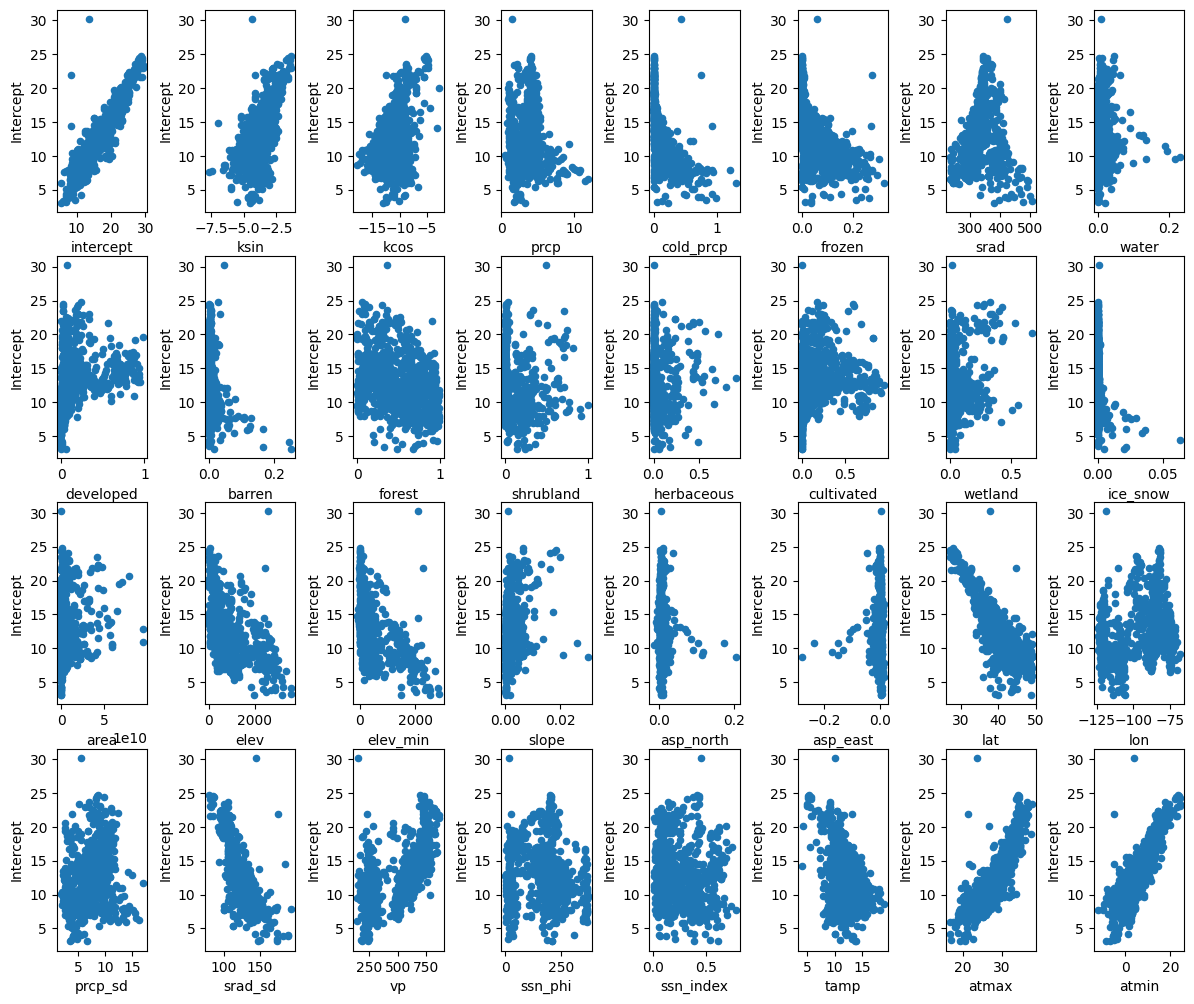

In [14]:
scatterplots("Intercept")

Relationship notes:

- The wetland effect appears to stand alone. It only correlates with other land covers, which it has to - though the effect is not strong.
- The elevation effect is identical to the relationship elevation has with mean air temperature.  Ignore elevation.
- Mean air temperature and latitude correlate very well, and it looks like that probably dominates the latitude effect.
- Vapor pressure has an interesting, and surprising, mapping to srad_sd, which seems to mirror its relationship to mean temperature.
- Latitude's effect is captured in mean air temperature.
- srad_sd seems to map well to mean air temperature, as a proxy for latitude.  Not worthwhile standalone.
- tamp, likewise.
- Developed, likewise.
- Slope has a negative correlation, but only over a certain slope.  Probably just maps to elevation (mountain watersheds).

Basically, all weather variables (and latitude) are correlating as proxies for mean air temperature.  However, forest and wetland have standalone effects - though the effect of wetlands disappears on closer inspection.

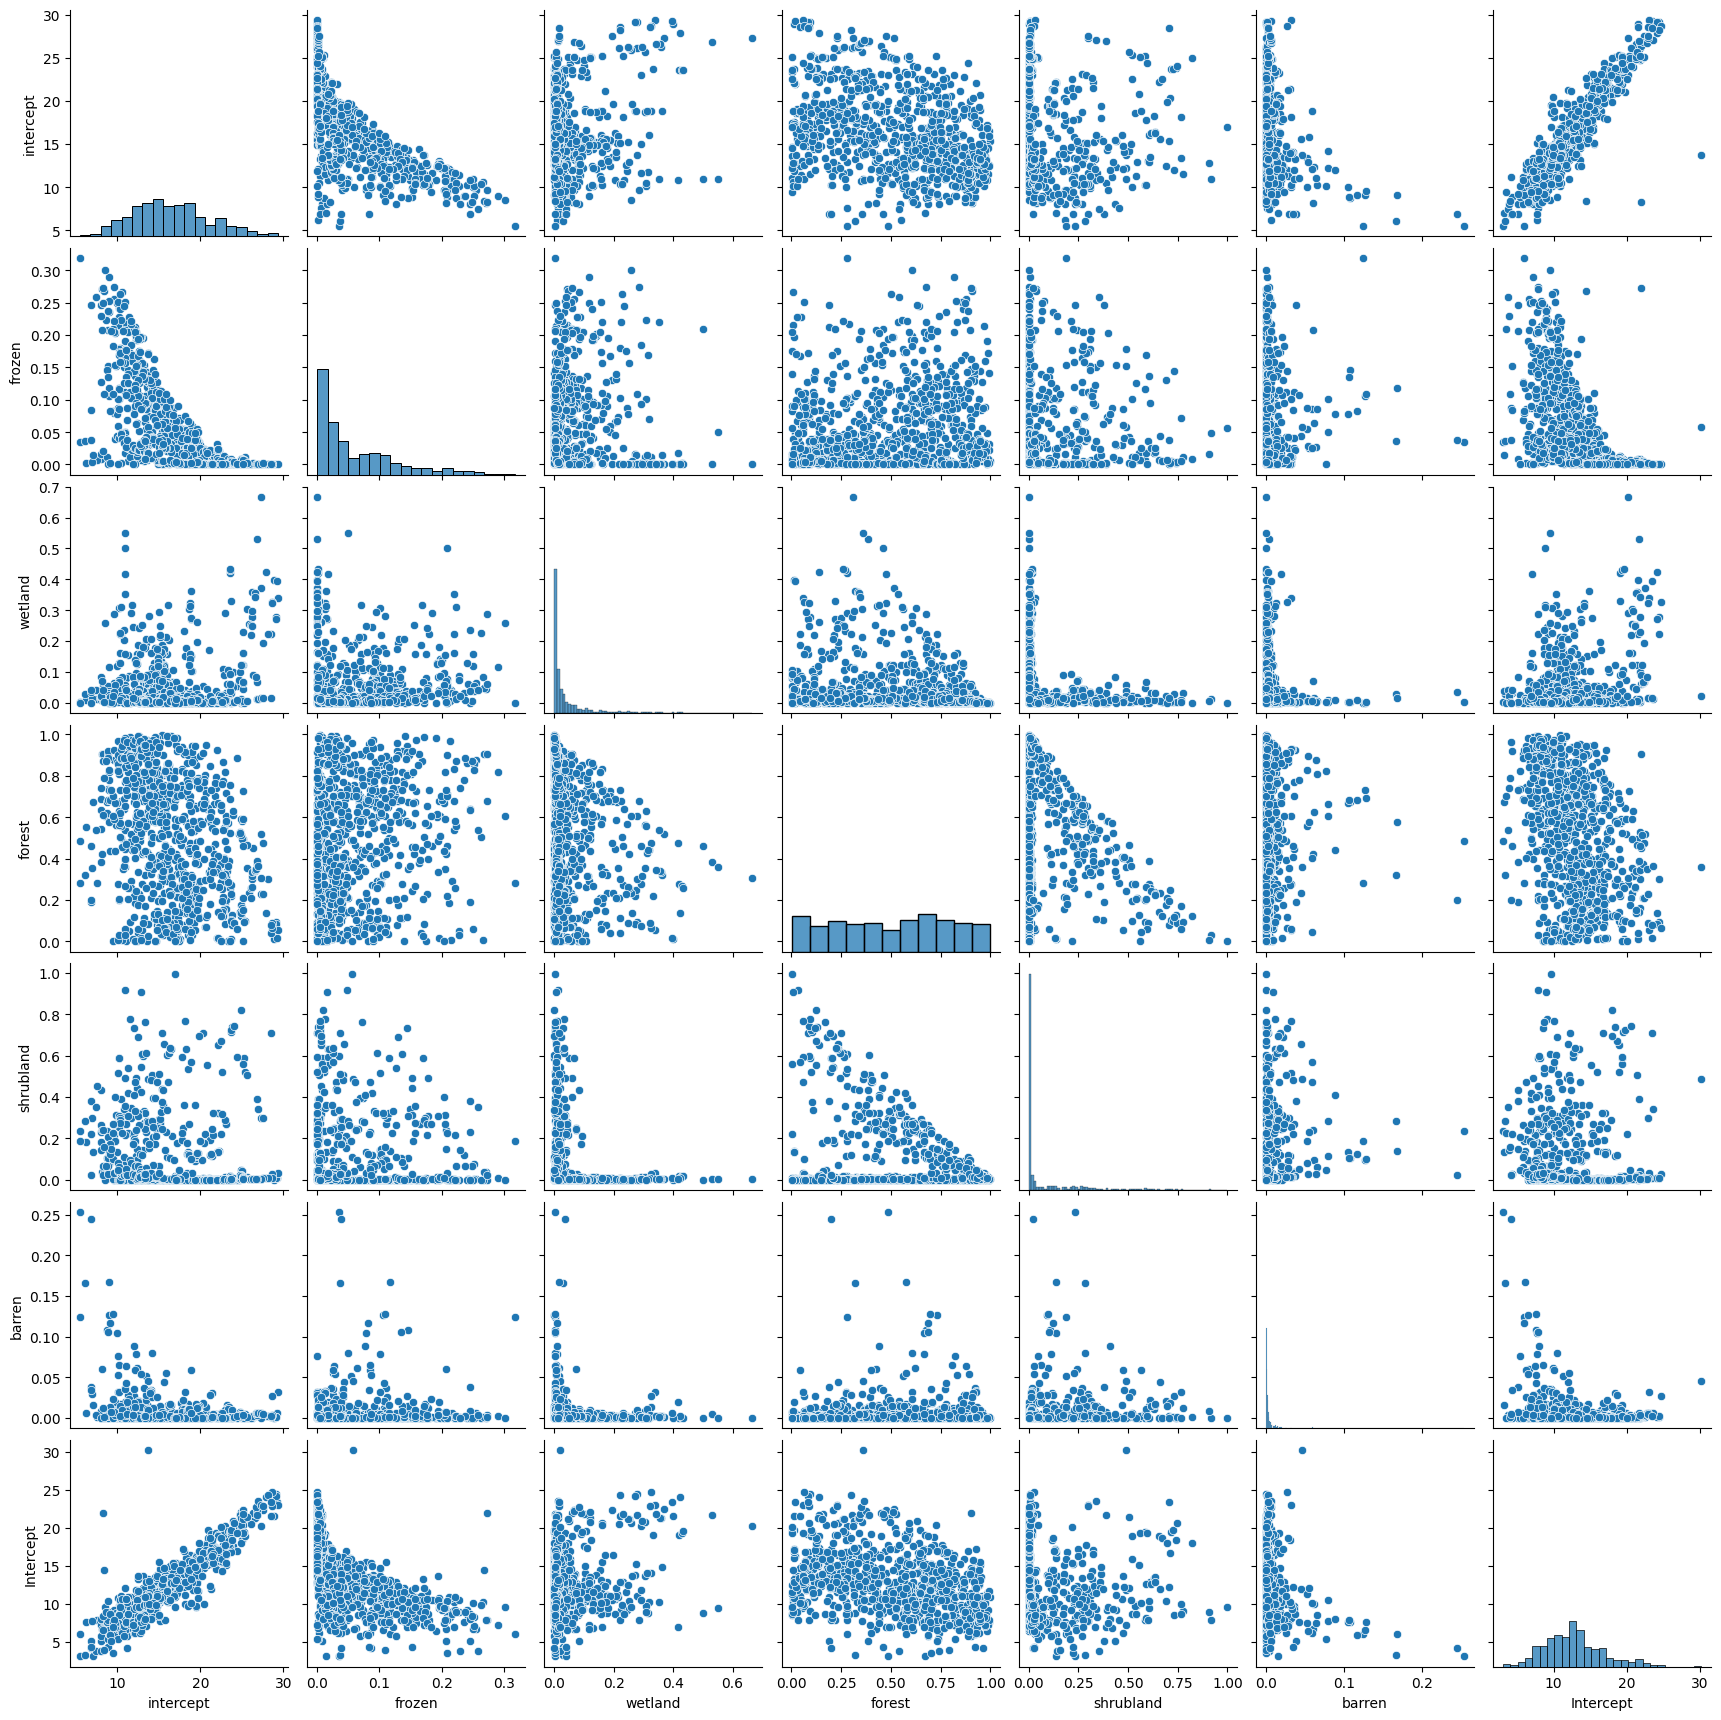

In [21]:
focused_scatters("Intercept", ["intercept", "frozen", "wetland", "forest", "shrubland", "barren"])

In [166]:
gam_itx = LinearGAM(s(0) + s(1), lam=100).fit(pds[["intercept", "forest"]], pds["Intercept"])
gam_itx.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     10.3567
Link Function:                     IdentityLink Log Likelihood:                                 -1883.5432
Number of Samples:                          923 AIC:                                             3789.7997
                                                AICc:                                            3790.1079
                                                GCV:                                                 2.576
                                                Scale:                                              2.5241
                                                Pseudo R-Squared:                                   0.8437
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_8244\3273960421.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_itx.summary()


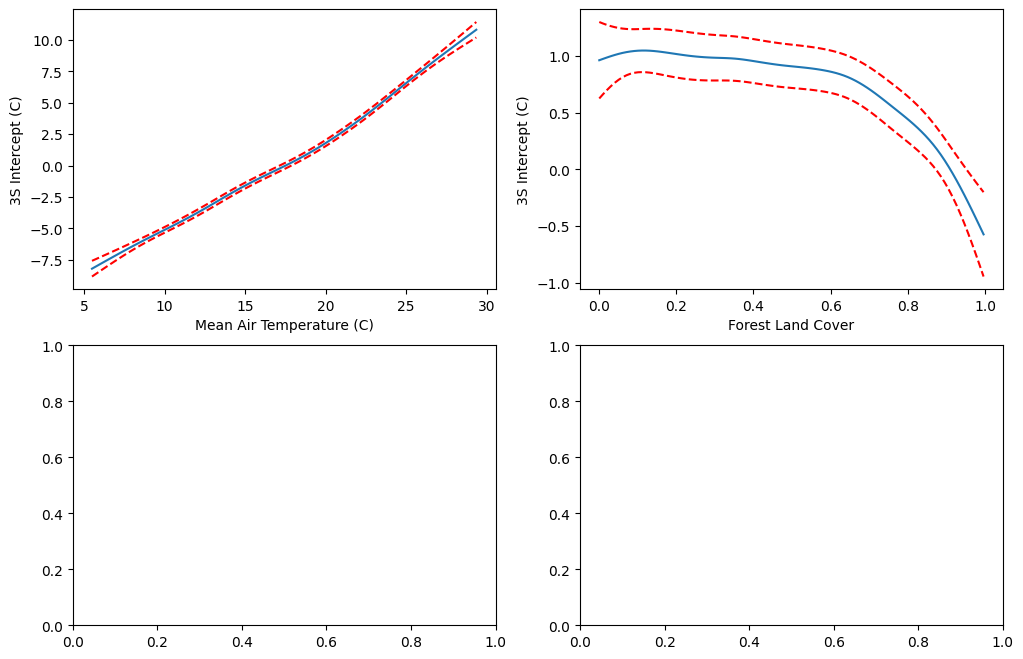

In [168]:
pdps(gam_itx, False, ["Mean Air Temperature (C)", "Forest Land Cover"], "3S Intercept (C)", "results/PDPs/InterceptGAM.png")

Mean air temperature and forest pretty much do the job.  The effect is linear with mean air temperature at a slope of about 0.7, and seems to have a sort of backwards-logarithm (or 1-exp(x)) dropoff with forest; there's definitely a much stronger effect over ~60% forest density.  Possibly relates to shaded-channel proportion.  Total effect of forest is about 2 C.

Slope of log10(1.05-y) vs x for forest is roughly 2.  log10(1.05-y) = 2x-2, roughly, so y=1.05-exp(2*(x-1)).  Directly fitting is problematic because of positive and negative values (so taking a log doesn't work).  By hand tuning:

$$
    \Delta Intercept = -1.6\cdot\exp(5.5\cdot (forest-1))
$$

Below, a direct numpy implementation is compared.  The GAM, recall, had an R2 of about 0.85.  Overfitting will presumably have next to no effect with four coefficients (intercept, intercept-slope, forest-slope, forest exponent coefficient).  Hand-tuned fit is about equally good (R2 0.83).  I suspect further performance improvement would involve using point-scale data.

<Axes: >

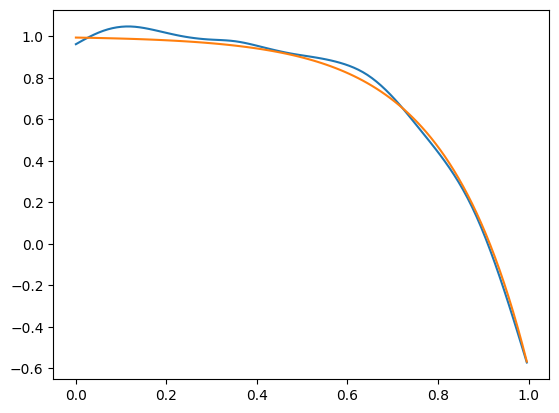

In [95]:
(x, y) = get_pd(gam_itx, 1)
ax=sns.lineplot(x=x, y=y)
yex = 1 - 1.6*np.exp(5.5*(x-1))
sns.lineplot(x=x, y=yex, ax=ax)

[[1.         0.83477977]
 [0.83477977 1.        ]]


<Axes: >

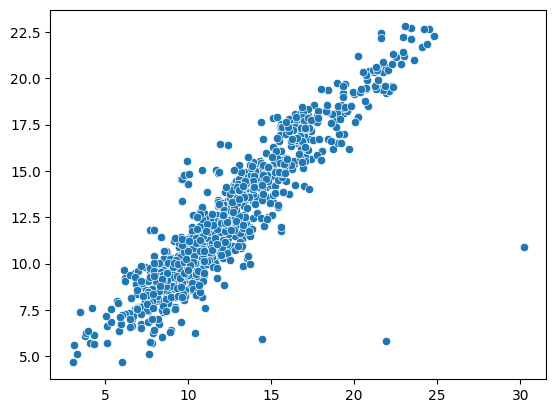

In [68]:
X = np.array([np.ones(len(pds)), pds["intercept"], np.exp(5.5*(pds["forest"]-1))]).transpose()
y = pds["Intercept"].to_numpy()
sol = np.linalg.lstsq(X, y, rcond=None)[0]
prd = X @ sol
print(np.corrcoef(prd, y)**2)
sns.scatterplot(x=y, y=prd)

## Amplitude

Here, we have more work to do, as a linear model only captures 55-60% of variance.  (Goes up to 70% for normalized version.)

- Correlates pretty strongly with atmin, and a bit with intercept
- Quite responsive to elevation
- Definite negative correlation with prcp_sd
- Frozen seems possibly relevant
- ssn_phi seems relevant, we'll try ssn_index too

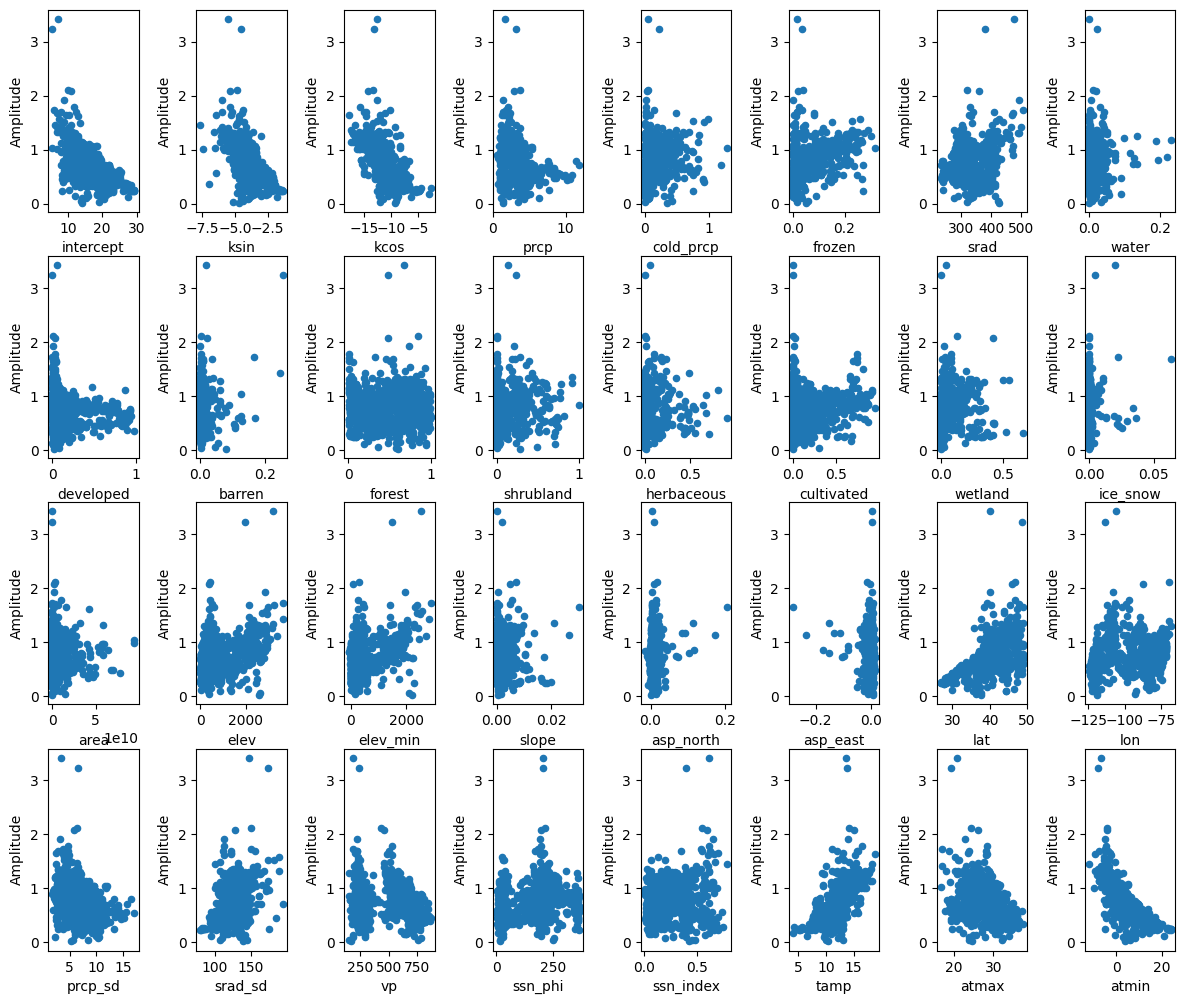

In [69]:
scatterplots("Amplitude")

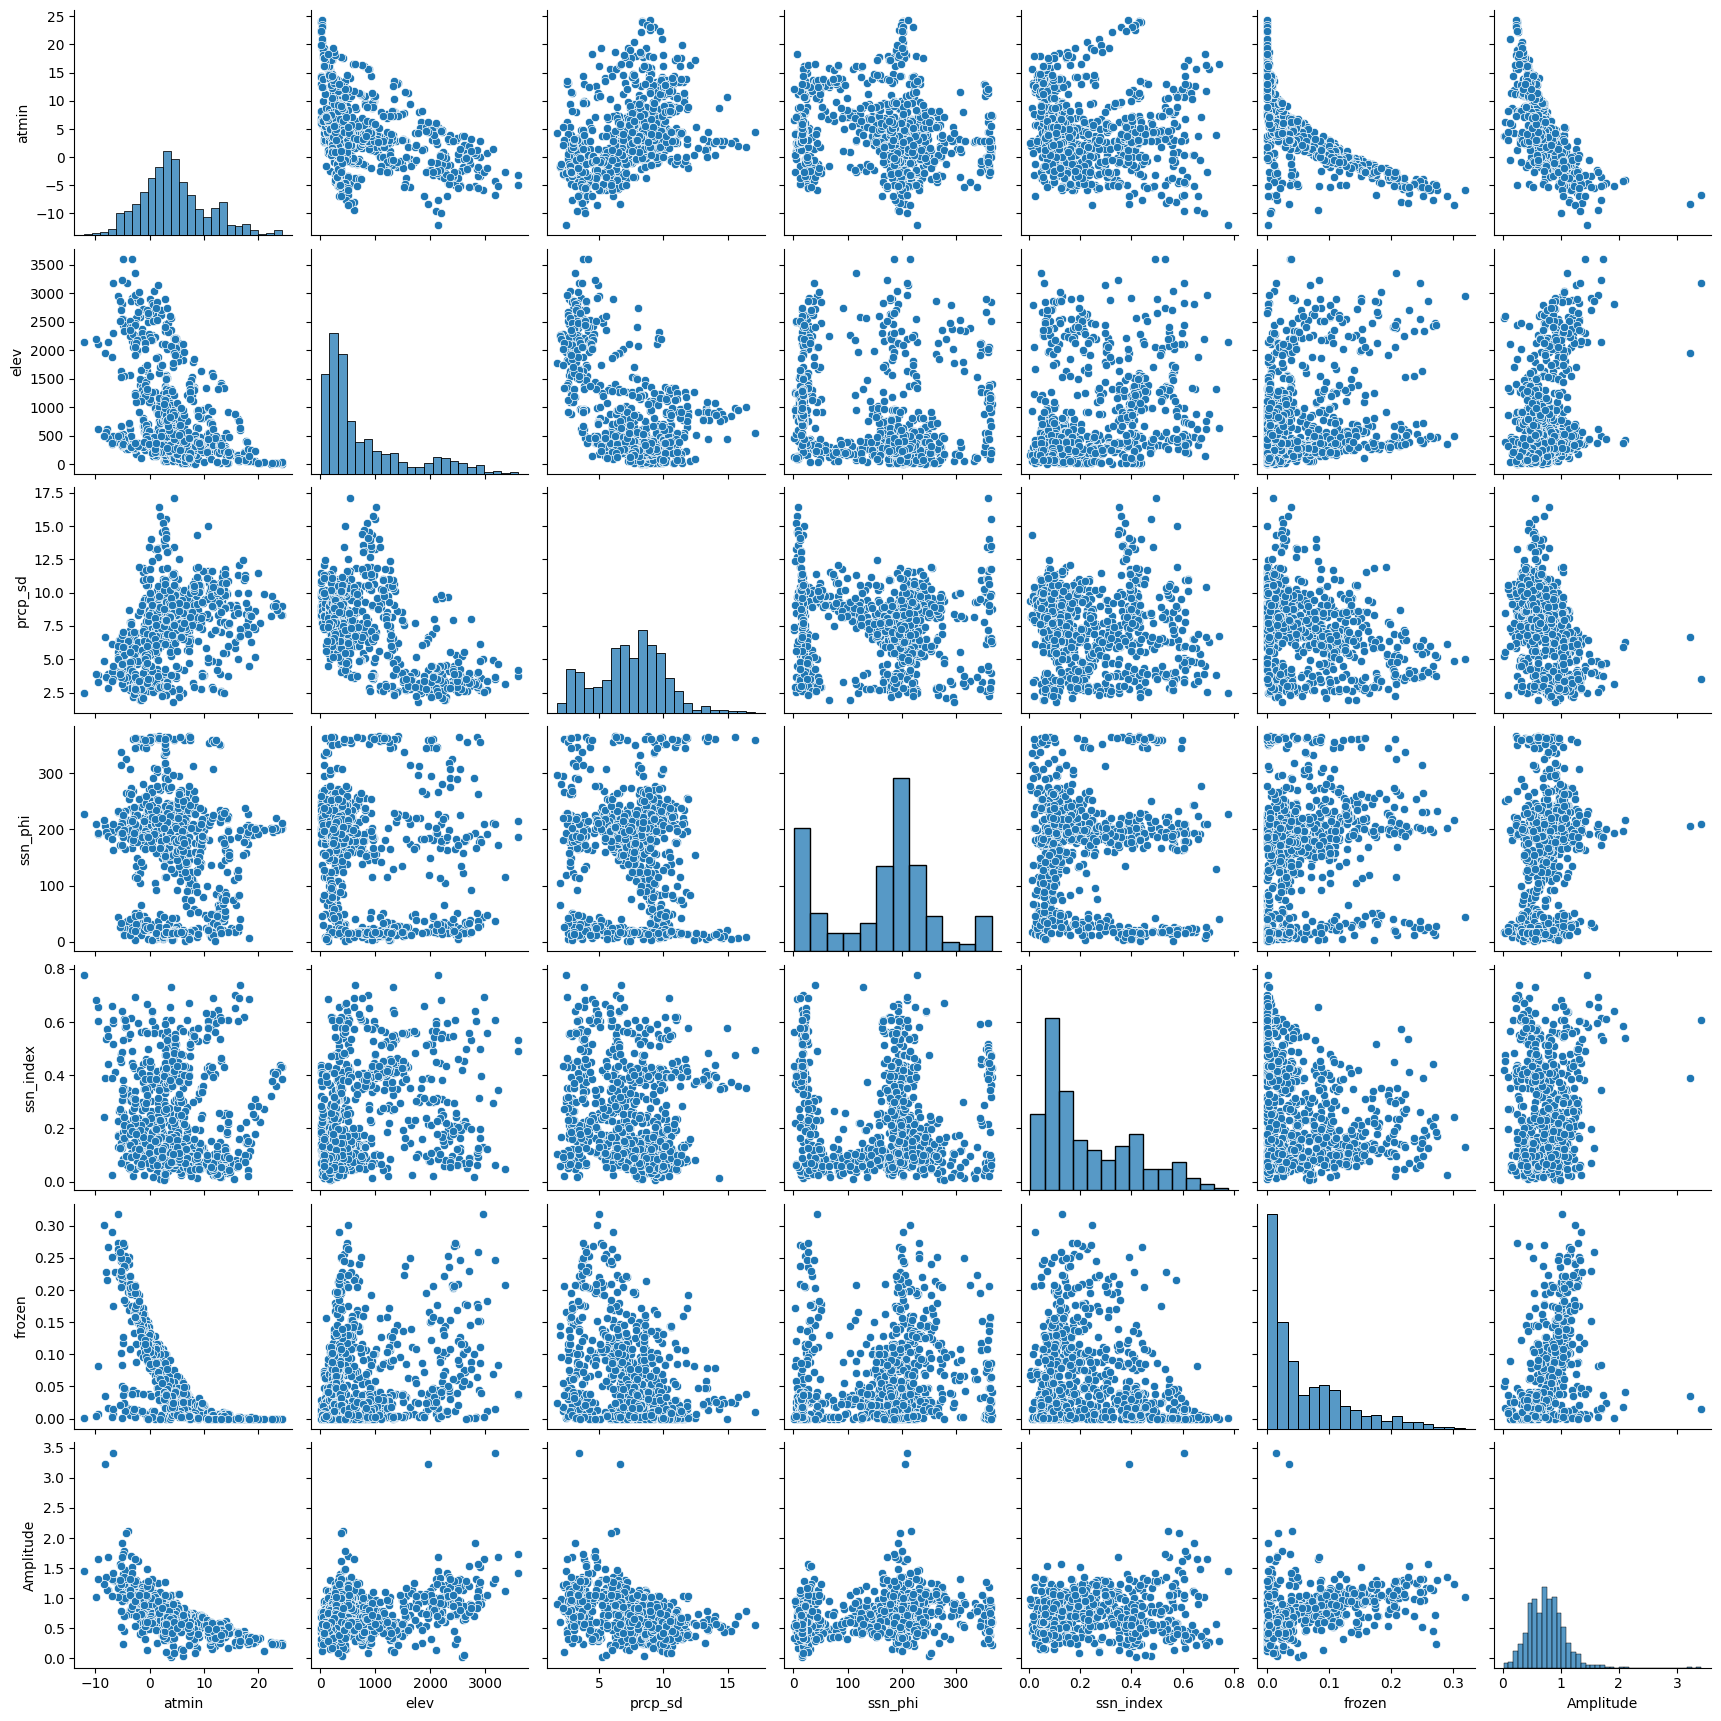

In [78]:
focused_scatters("Amplitude", ["atmin", "elev", "prcp_sd", "ssn_phi", "ssn_index", "frozen"])

In [112]:
gam_amp = LinearGAM(s(0) + s(1) + s(2), lam=10).fit(pds[["atmin", "elev", "cold_prcp"]], pds["Amplitude"])
gam_amp.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     20.9756
Link Function:                     IdentityLink Log Likelihood:                                -11009.7657
Number of Samples:                          923 AIC:                                            22063.4826
                                                AICc:                                           22064.6046
                                                GCV:                                                0.0354
                                                Scale:                                               0.034
                                                Pseudo R-Squared:                                   0.6738
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_8244\4085069242.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_amp.summary()


Optimal GAM (r2 0.68) for normalized version has minimum air temperature, elevation, and precipitation mean date.

- Air temperature is negative linear.
- Elevation looks like a threshold response around 2500 m, where it's roughly constant, then becomes linear.  (Interesting: this aligns with the extrapolation problem encountered elsewhere.  Maybe there's a major shift in phenomena around there?  The effect is quite large.)
- Precipitation mean date has a strong up-and-down effect.  Wet-summer sites have a high amplitude, wet-winter sites have a low amplitude. Effect is about 30% of mean temperature.  The shape is tricky because data are concentrated around winter and summer; spring and fall are quite sparse.  This one may be best served remaining as a GAM.
- This effect is better explained by cold (subzero) precipitation, which also has a much stronger effect (~60%), though correlation is the same (R2 0.67).

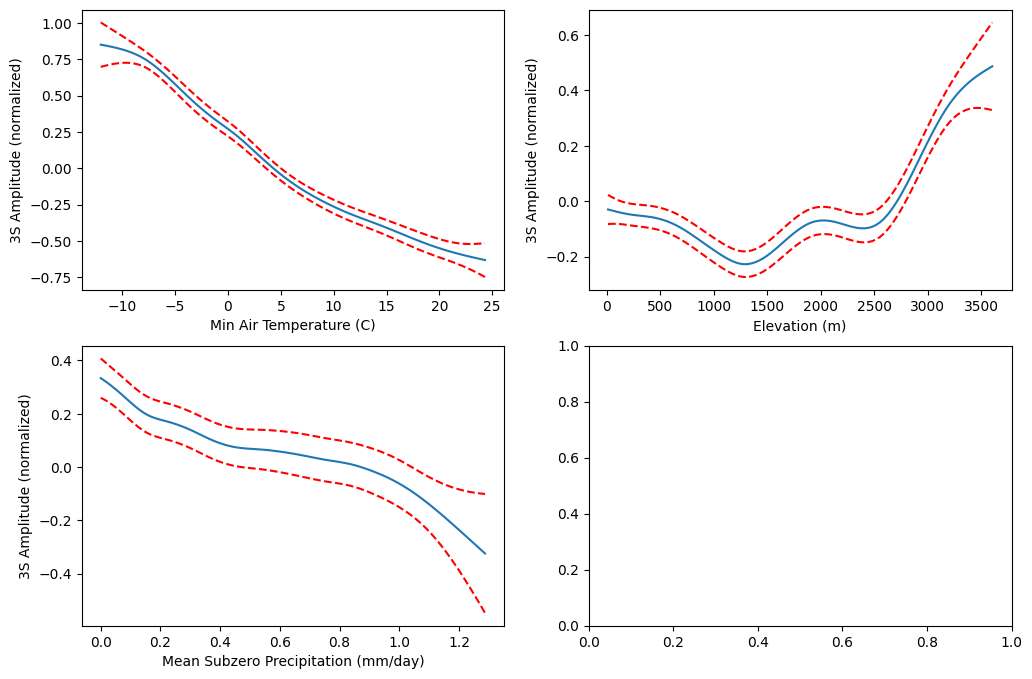

In [170]:
pdps(gam_amp, False, ["Min Air Temperature (C)", "Elevation (m)", "Mean Subzero Precipitation (mm/day)"], "3S Amplitude (normalized)", "results/PDPs/AmplitudeGAM.png")

<Axes: >

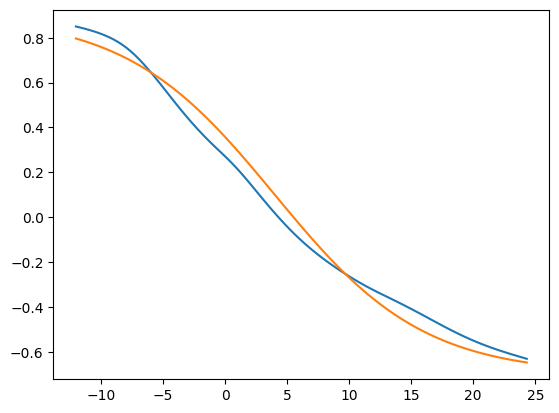

In [151]:
(x, y) = get_pd(gam_amp, 0)
ax=sns.lineplot(x=x, y=y)
# Cold precip looks linear.  Elev seems... quadratic?  Max of 2000**2, but want effect of 0.7.  I bet that initial drop is spurious though.
# And atmin looks sort of logistic, centered around 4 with decay coefficient 6.
yp = 0.9 - 1.6/(1 + np.exp(-(x - 4) / 6))
sns.lineplot(x=x, y=yp, ax=ax)

[[1.         0.67383273]
 [0.67383273 1.        ]]


<Axes: >

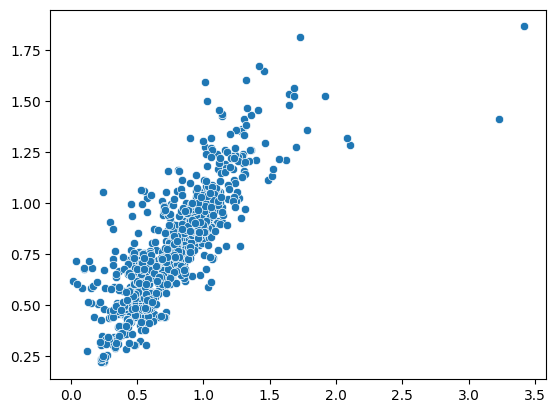

In [158]:
logist = lambda x: 1/(1 + np.exp(-(x-4) / 6))
X = np.array([np.ones(len(pds)), logist(pds["atmin"]), pds["elev"]*(pds["elev"]>2500), pds["cold_prcp"]]).transpose()
y = pds["Amplitude"].to_numpy()
sol = np.linalg.lstsq(X, y, rcond=None)[0]
prd = gam_amp.predict(pds[["atmin", "elev", "cold_prcp"]])
print(np.corrcoef(prd, y)**2)
sns.scatterplot(x=y, y=prd)

## SpringSummer

SpringSummer has a lot of interesting relationships:

- Definite exponential decay with intercept
- Looks like a slight positive correlation with precip
- Very definite threshold response with developed, cultivated, and wetland
- Correlates with slope
- Correlates with srad_sd
- Correlates very strongly with cold_prcp

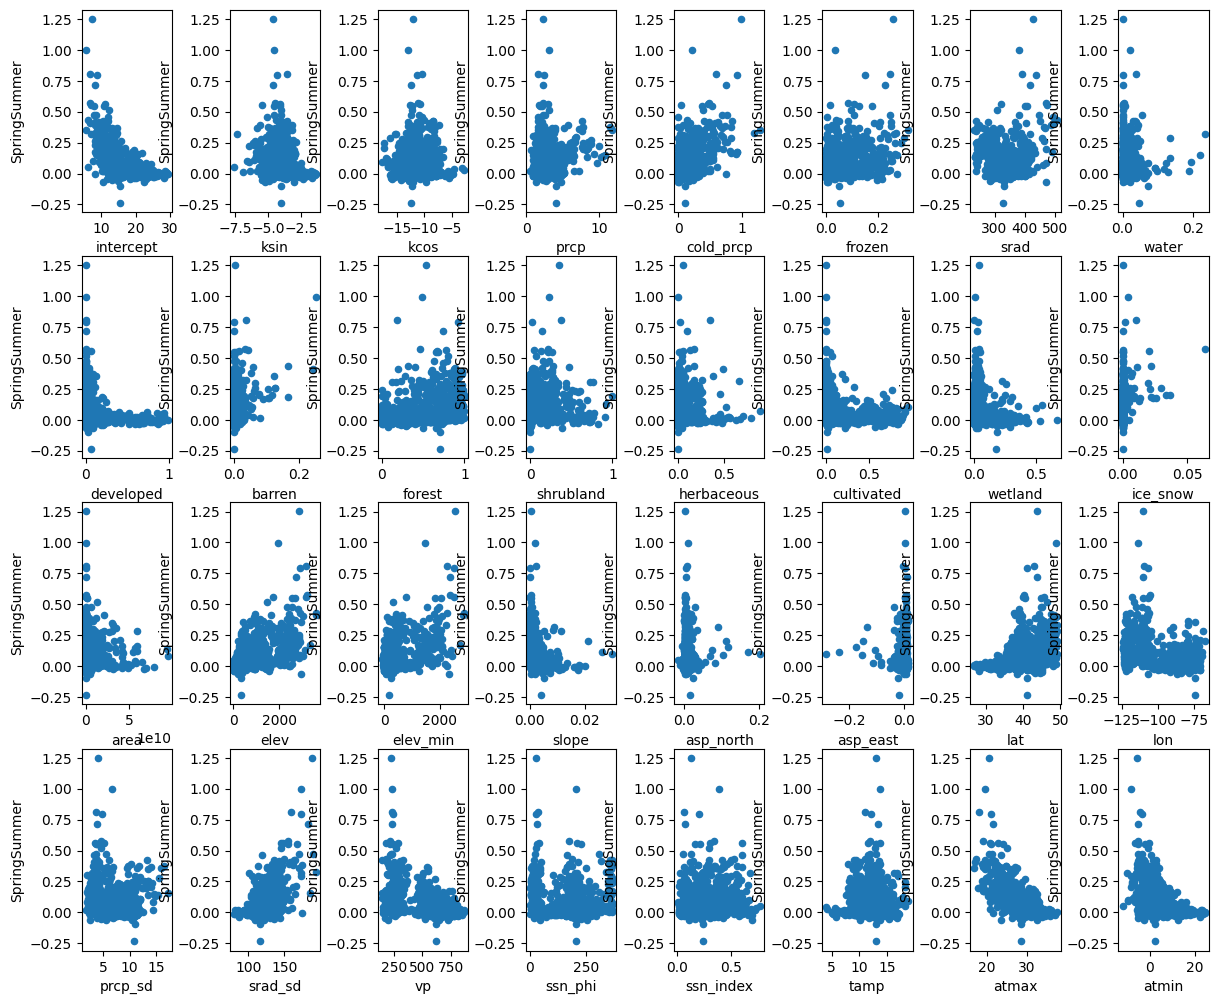

In [171]:
scatterplots("SpringSummer")

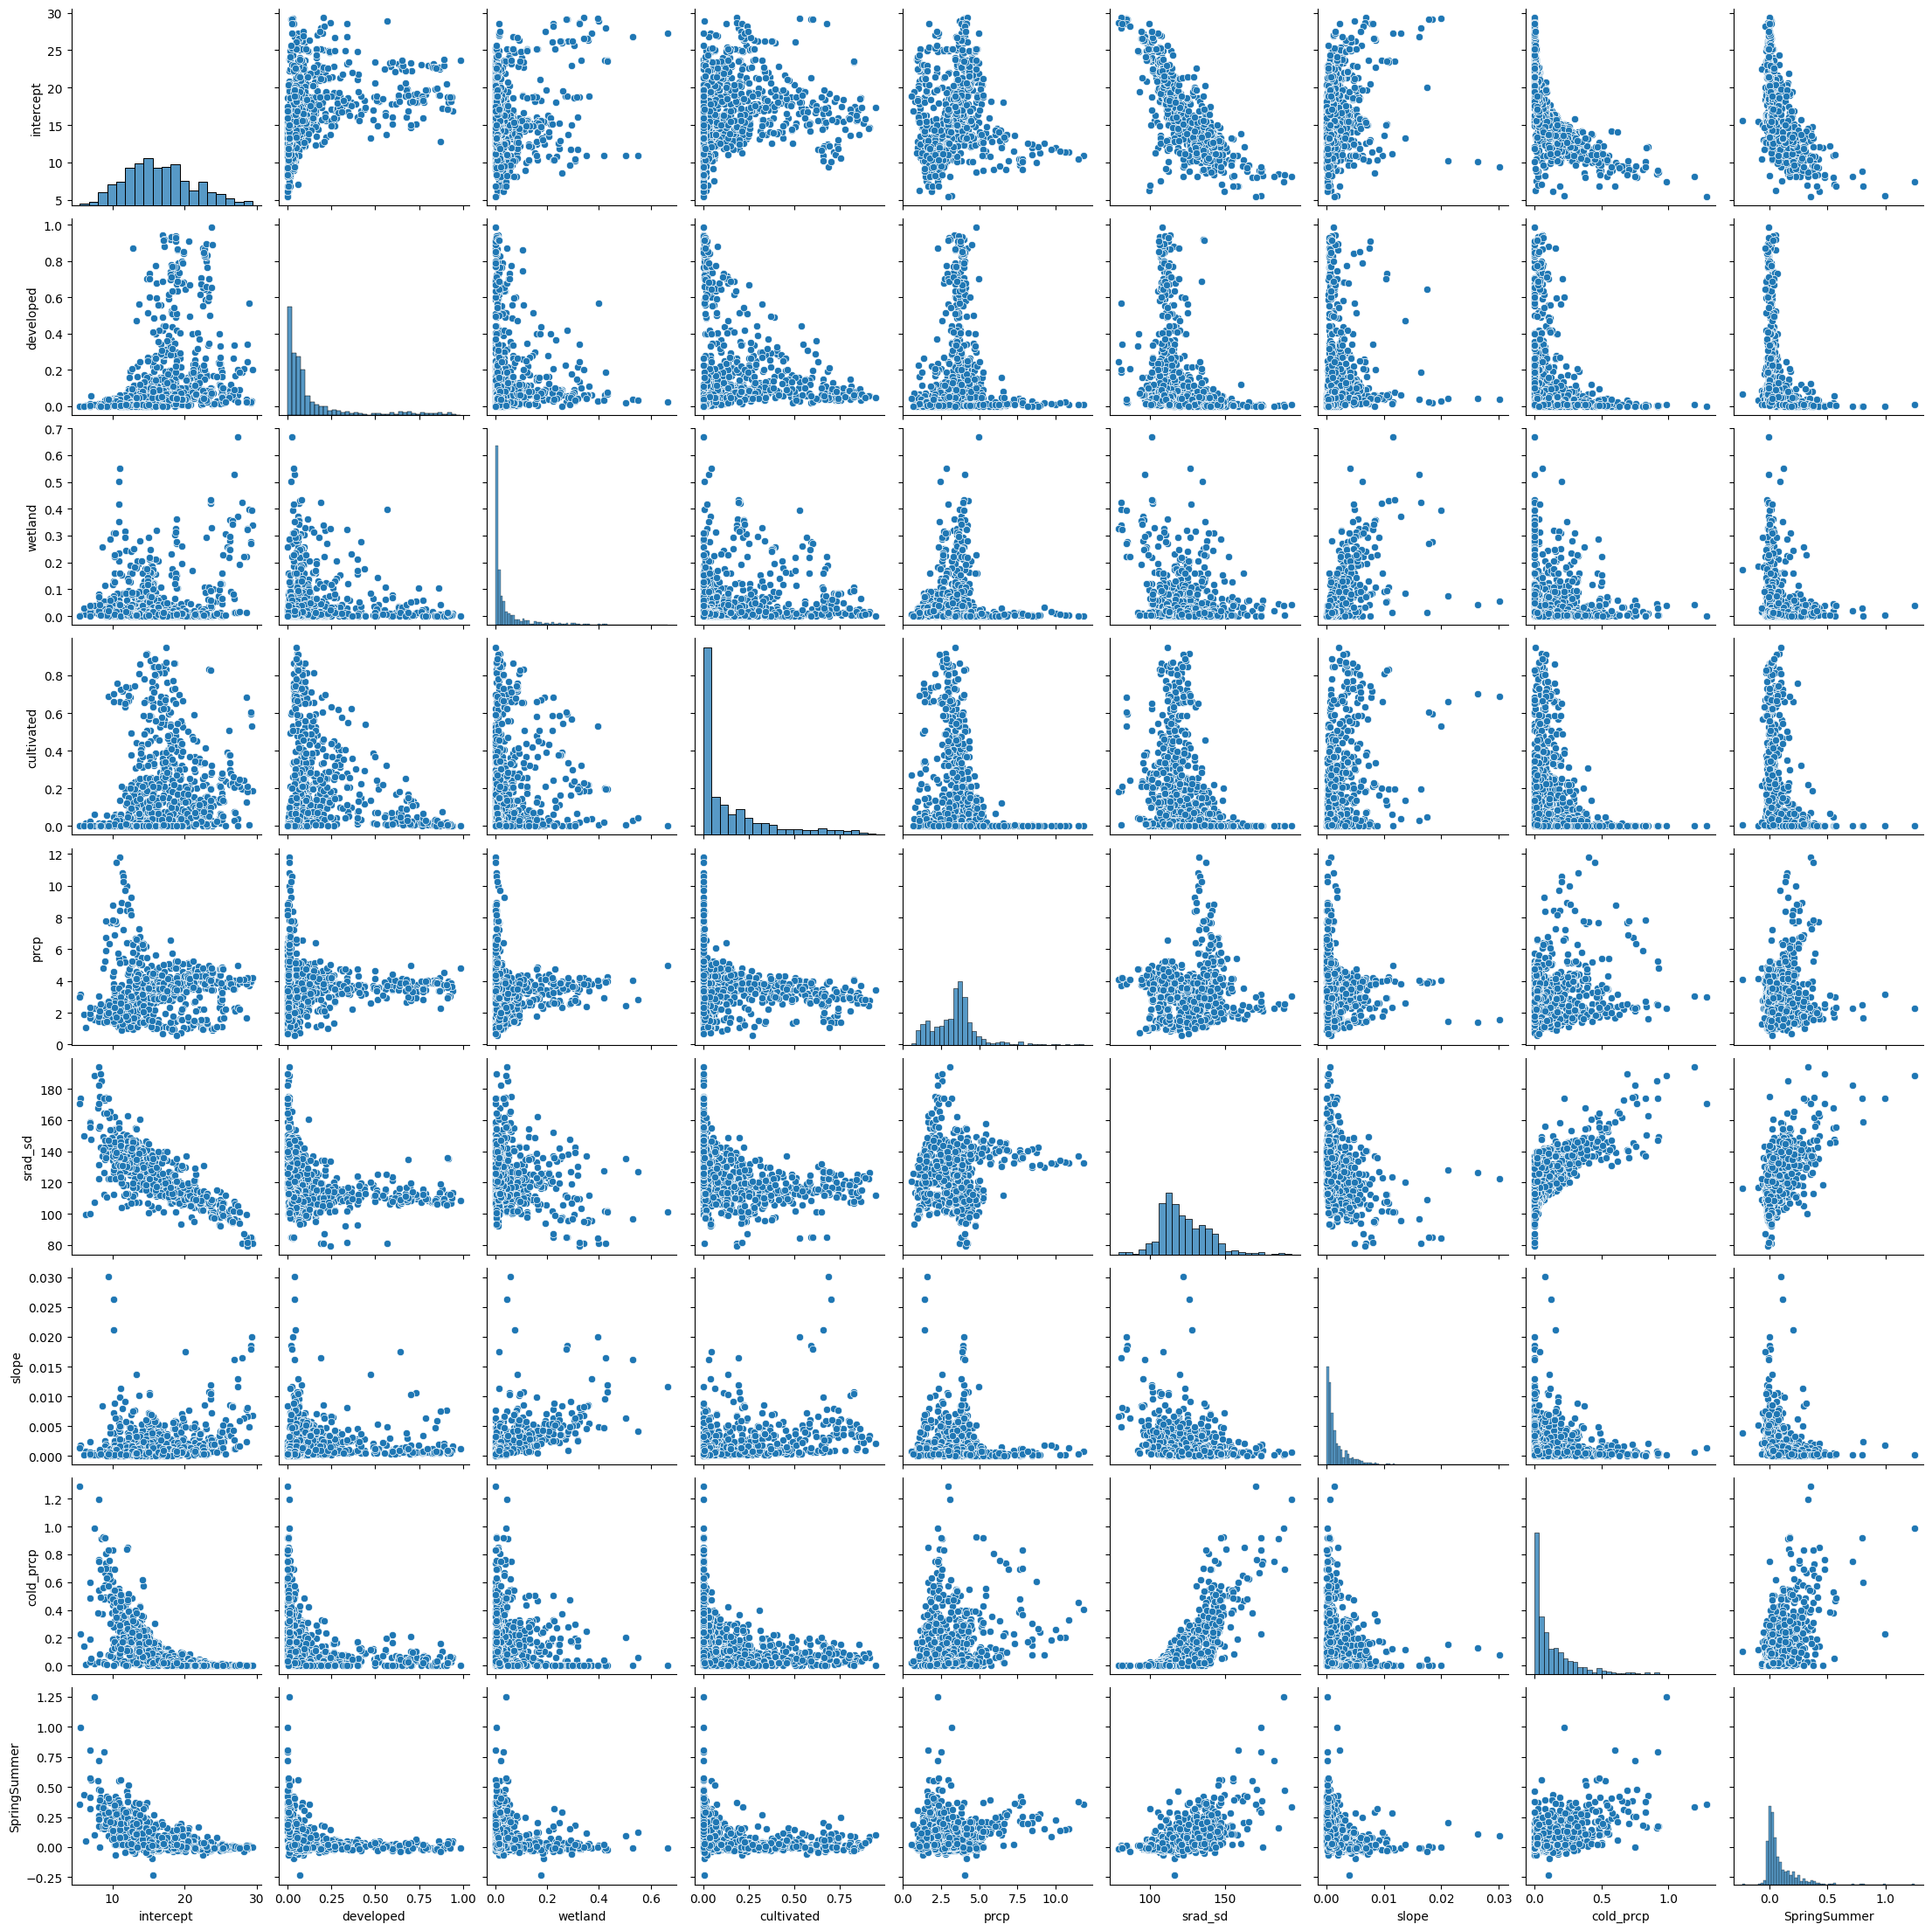

In [172]:
focused_scatters("SpringSummer", ["intercept", "developed", "wetland", "cultivated", "prcp", "srad_sd", "slope", "cold_prcp"])

In [200]:
gam_ssu = LinearGAM(s(0) + s(1) + s(2), lam=10).fit(pds[["intercept", "prcp", "srad_sd"]], pds["SpringSummer"])
gam_ssu.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     21.1438
Link Function:                     IdentityLink Log Likelihood:                                -63446.4672
Number of Samples:                          923 AIC:                                           126937.2221
                                                AICc:                                          126938.3611
                                                GCV:                                                 0.007
                                                Scale:                                              0.0067
                                                Pseudo R-Squared:                                   0.5776
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_8244\2899794493.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_ssu.summary()


Optimal normalized GAM has intercept, prcp, srad_sd, with an R2 of 0.58.

- intercept is exponential decay.
- Subzero precipitation is doing this noisy linear thing.
- srad_sd looks sort of exponential or quadratic.

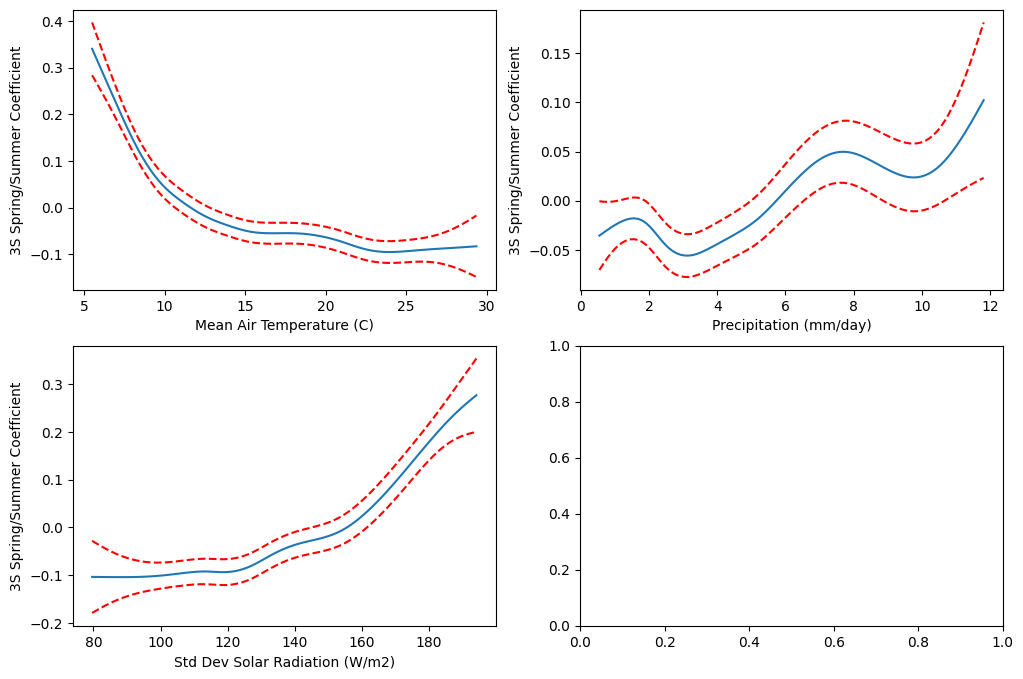

In [201]:
pdps(gam_ssu, False, ["Mean Air Temperature (C)", "Precipitation (mm/day)", "Std Dev Solar Radiation (W/m2)"], "3S Spring/Summer Coefficient", "results/PDPs/SpringSummerGAM.png")

<Axes: >

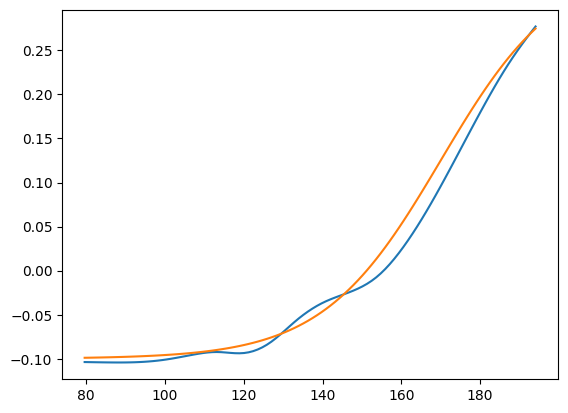

In [252]:
(x, y) = get_pd(gam_ssu, 2)
ax=sns.lineplot(x=x, y=y)
# intercept is definitely exponential decay.  Starts from ~0.4 at 5.  Drops to -0.1.  Looks like decay rate is about 20%.
# yp = -0.1 + 0.5 * np.exp(-(x-5) / 5)
# Precipitation looks kinda like sin(x)+x, which has got to be spurious, but there's a linear relationship in there too.
# yp = -0.06 + 0.14/12 * x + 0.03*np.sin((x+0.5)*2*np.pi/6)
# Solar radiation looks exponential, or quadratic.  Logistic is probably a safer bet.  Center at 170 and decay rate of 1/15 works pretty well.
yp = -0.1 + 0.45/(1 + np.exp(-(x - 170) / 15))
sns.lineplot(x=x, y=yp, ax=ax)

[[1.         0.53907278]
 [0.53907278 1.        ]]


<Axes: >

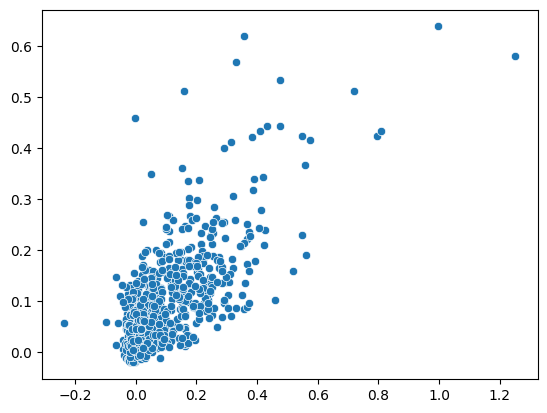

In [258]:
srad = lambda x: 1/(1 + np.exp(-(x-170) / 15))
itx = lambda x: np.exp(-(x-5)/5)
prcp = lambda x: 0.14/12 * x + 0.03*np.sin((x+0.5)*2*np.pi/6)
X = np.array([np.ones(len(pds)), itx(pds["intercept"]), pds["prcp"], srad(pds["srad_sd"])]).transpose()
y = pds["SpringSummer"].to_numpy()
sol = np.linalg.lstsq(X, y, rcond=None)[0]
prd = X @ sol
# prd = gam_ssu.predict(pds[["intercept", "prcp", "srad_sd"]])
print(np.corrcoef(prd, y)**2)
sns.scatterplot(x=y, y=prd)

## FallWinter

- Slight negative relationship with mean air temperature, or better with atmin.  Doesn't respond as much to other temperature stuff.
- Threshold response to developed.
- Threshold response to precipitation.
- Looks like it may have a positive correlation with srad.
- Definite positive correlation with elevation.
- Negative correlation with precip-sd.

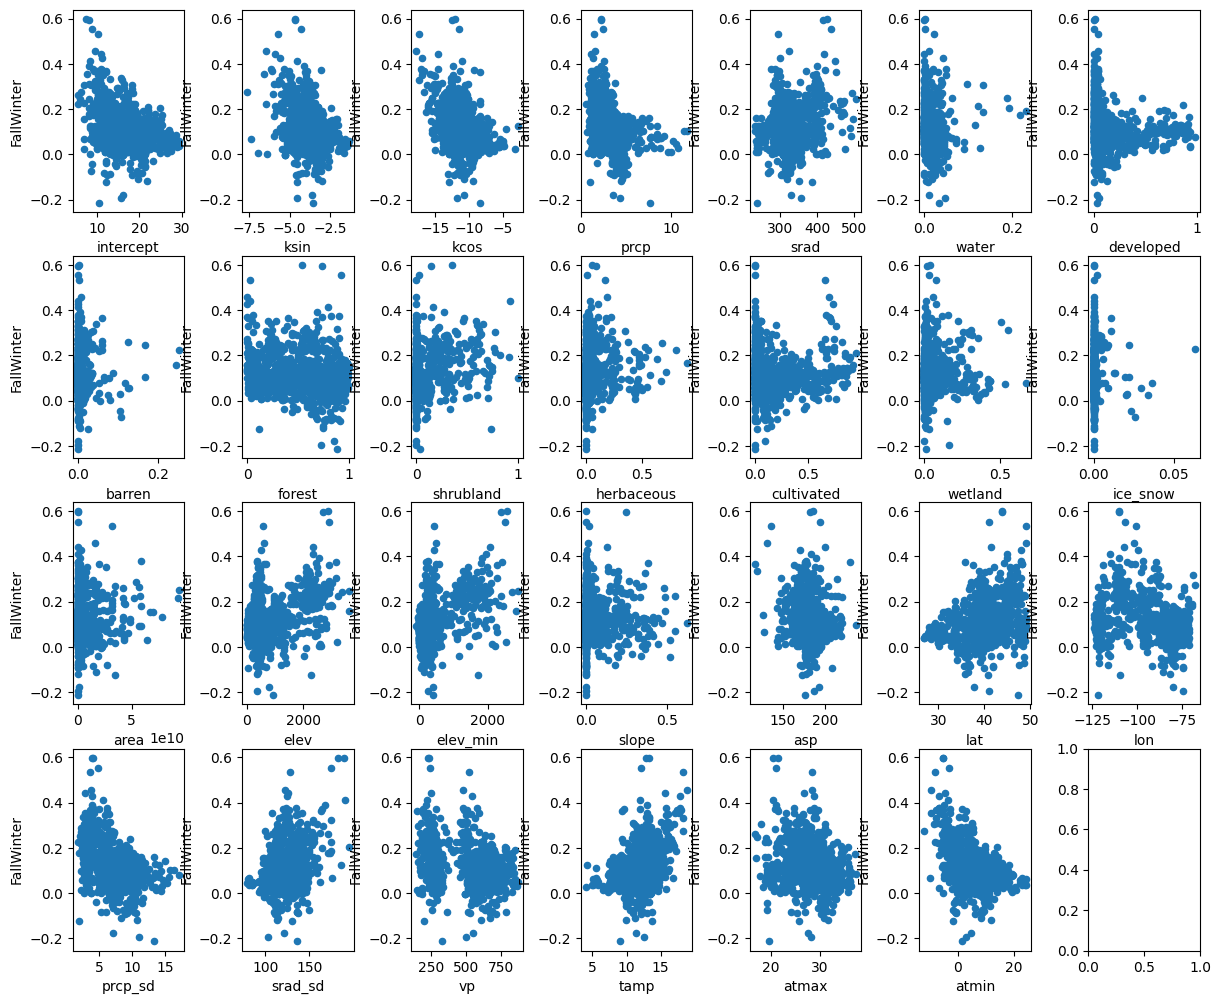

In [68]:
scatterplots("FallWinter")

In [76]:
gam_fw = LinearGAM(s(0) + s(1) + s(2) + s(3), lam=10).fit(pds[["atmin", "prcp", "prcp_sd", "elev"]], pds["FallWinter"])
gam_fw.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     27.8291
Link Function:                     IdentityLink Log Likelihood:                                 -86663.114
Number of Samples:                          923 AIC:                                           173383.8862
                                                AICc:                                          173385.8118
                                                GCV:                                                0.0052
                                                Scale:                                              0.0049
                                                Pseudo R-Squared:                                   0.4163
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_4136\707467660.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_fw.summary()


Optimal GAM (R2 0.42) has atmin, prcp, prcp_sd, elev.

- Linear-to-threshold response to atmin; basically, no fall/winter if atmin > 0 (does not freeze).  (Hint: suggests relevance of freeze_days...)
- Negative linear with prcp
- Positive linear with prcp_sd
- Logistic or threshold with elev, looks like it goes linear past about 1200 m

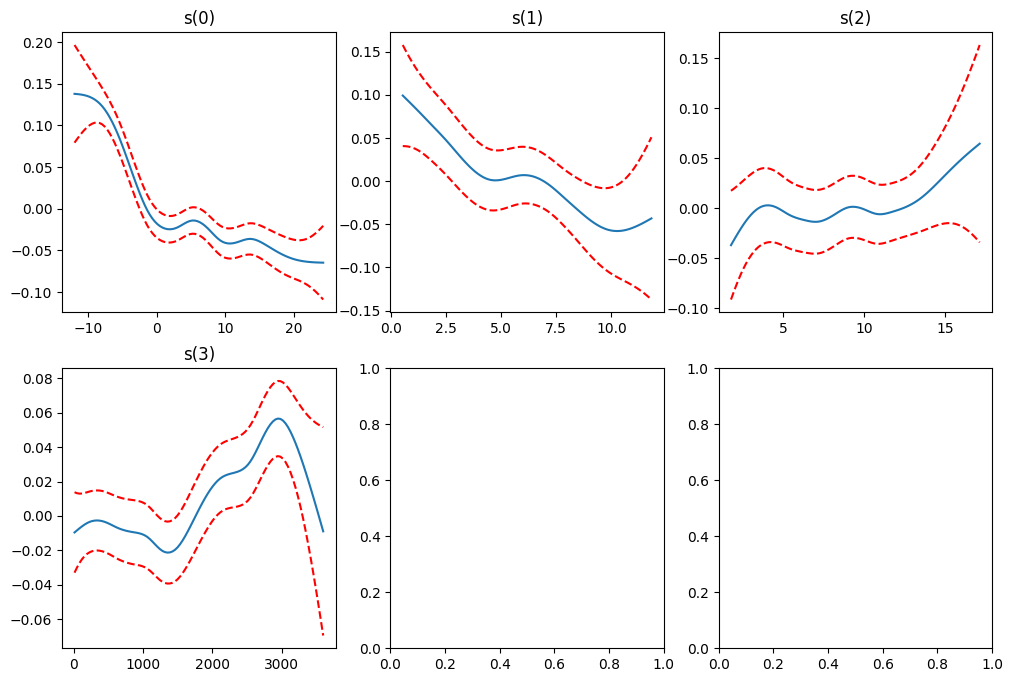

In [77]:
pdps(gam_fw, False)

## SpringDay

SpringDay is *wildly* noisy with respect to pretty much everything.  I do not see a good way to predict it.

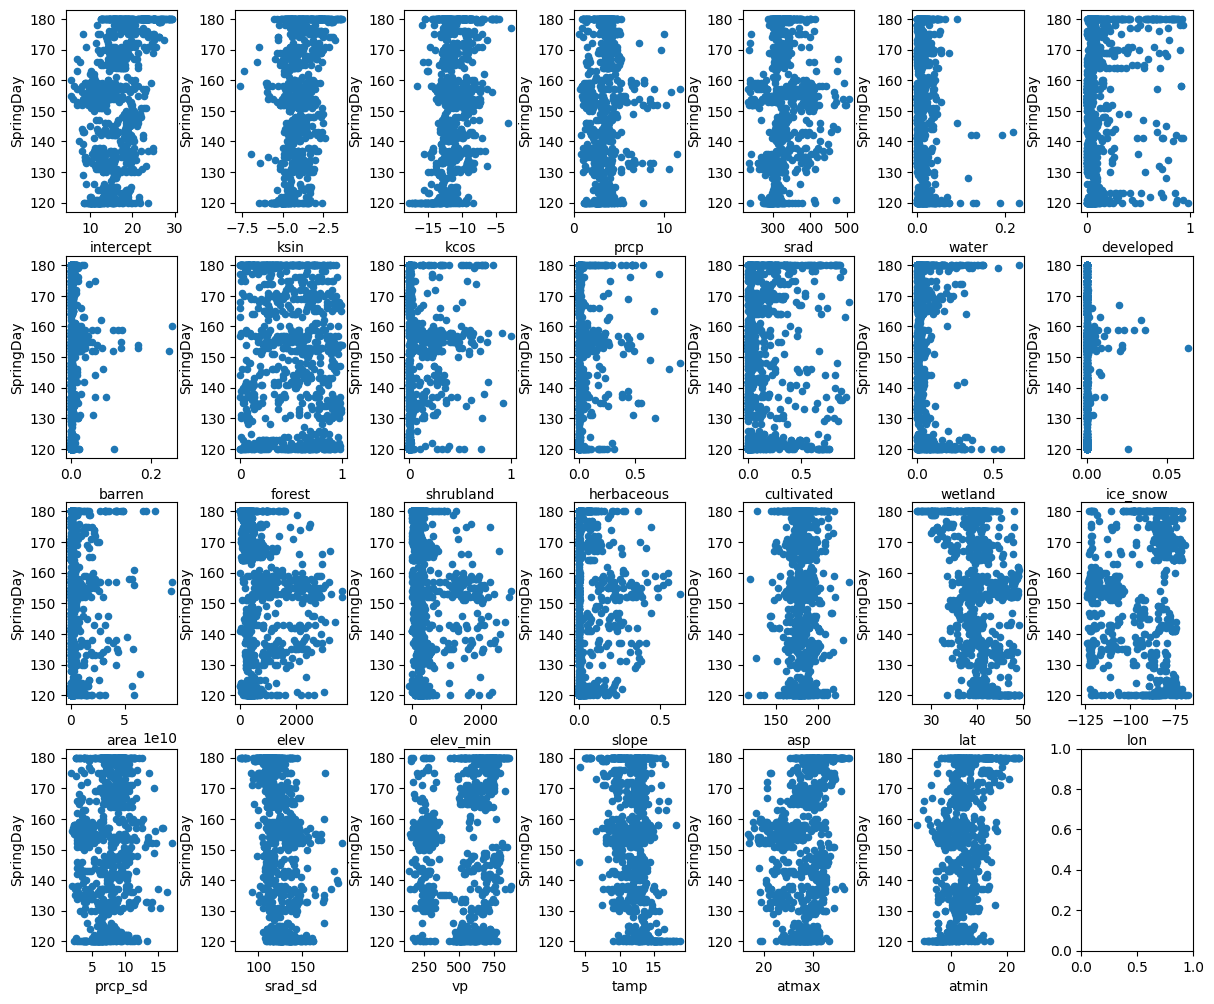

In [78]:
scatterplots("SpringDay")

## SummerDay

SummerDay is also extraordinarily noisy; I don't see a useful pattern.

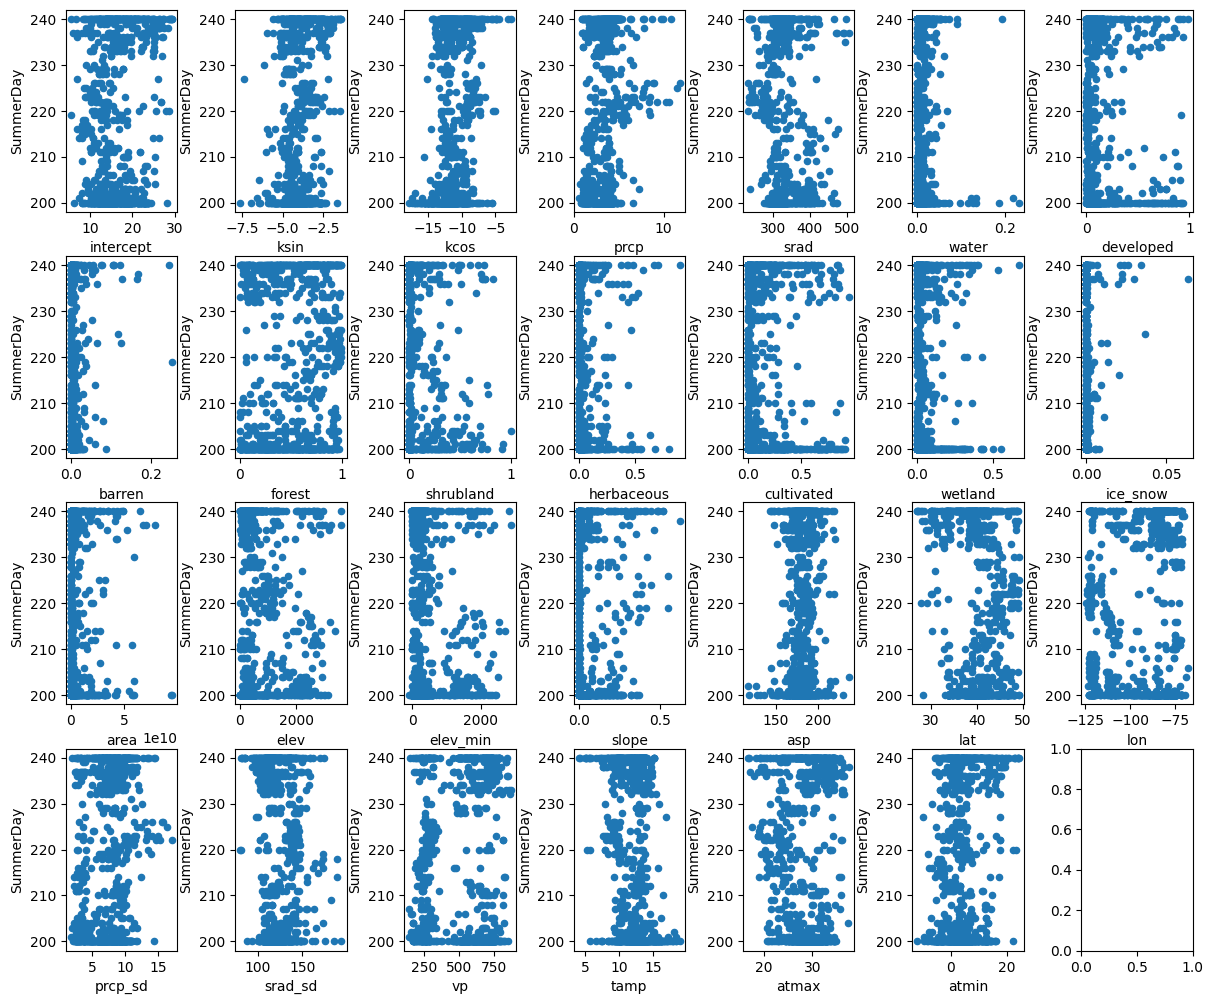

In [79]:
scatterplots("SummerDay")

## FallDay

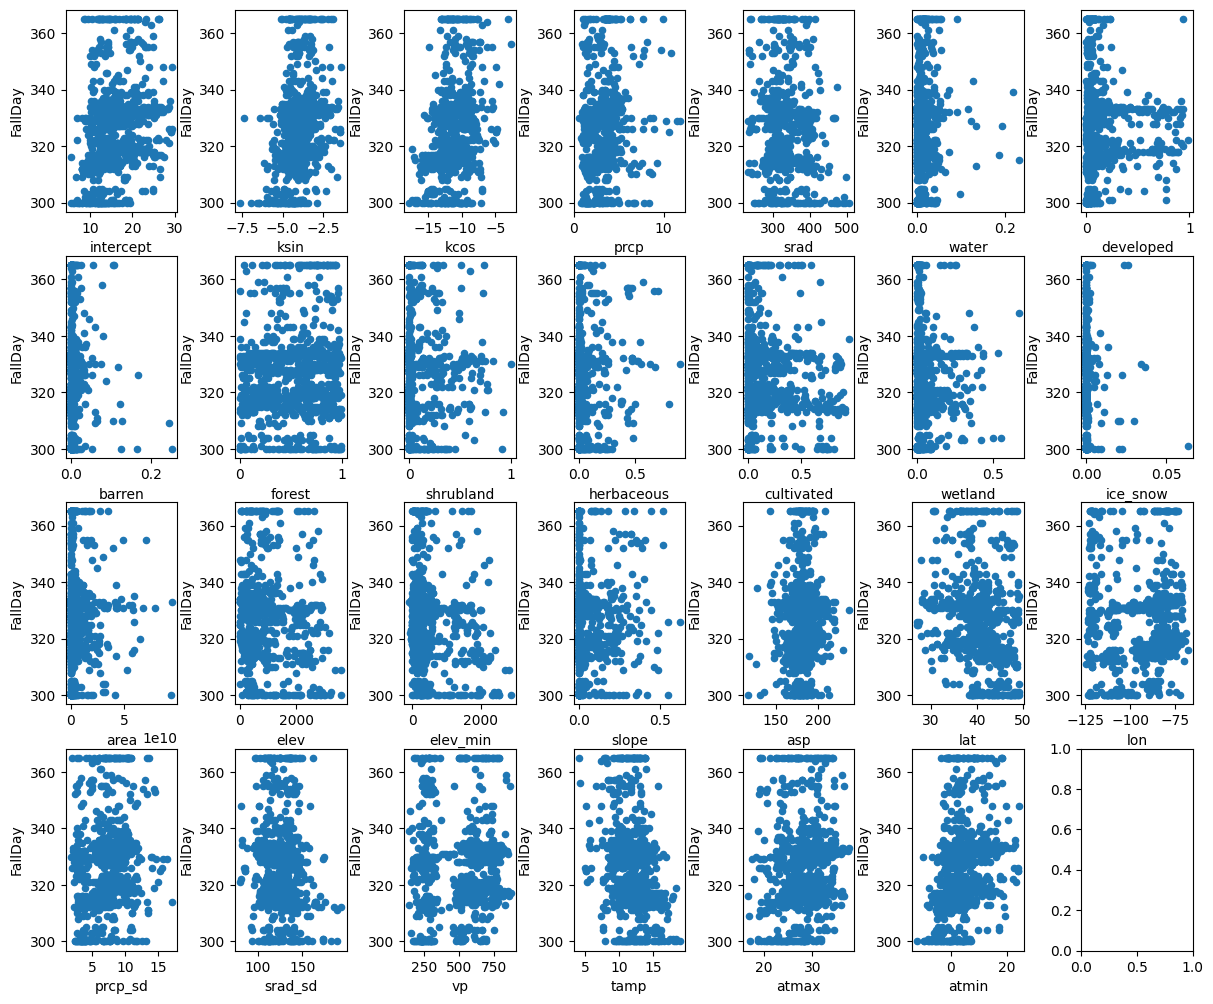

In [80]:
scatterplots("FallDay")

## WinterDay

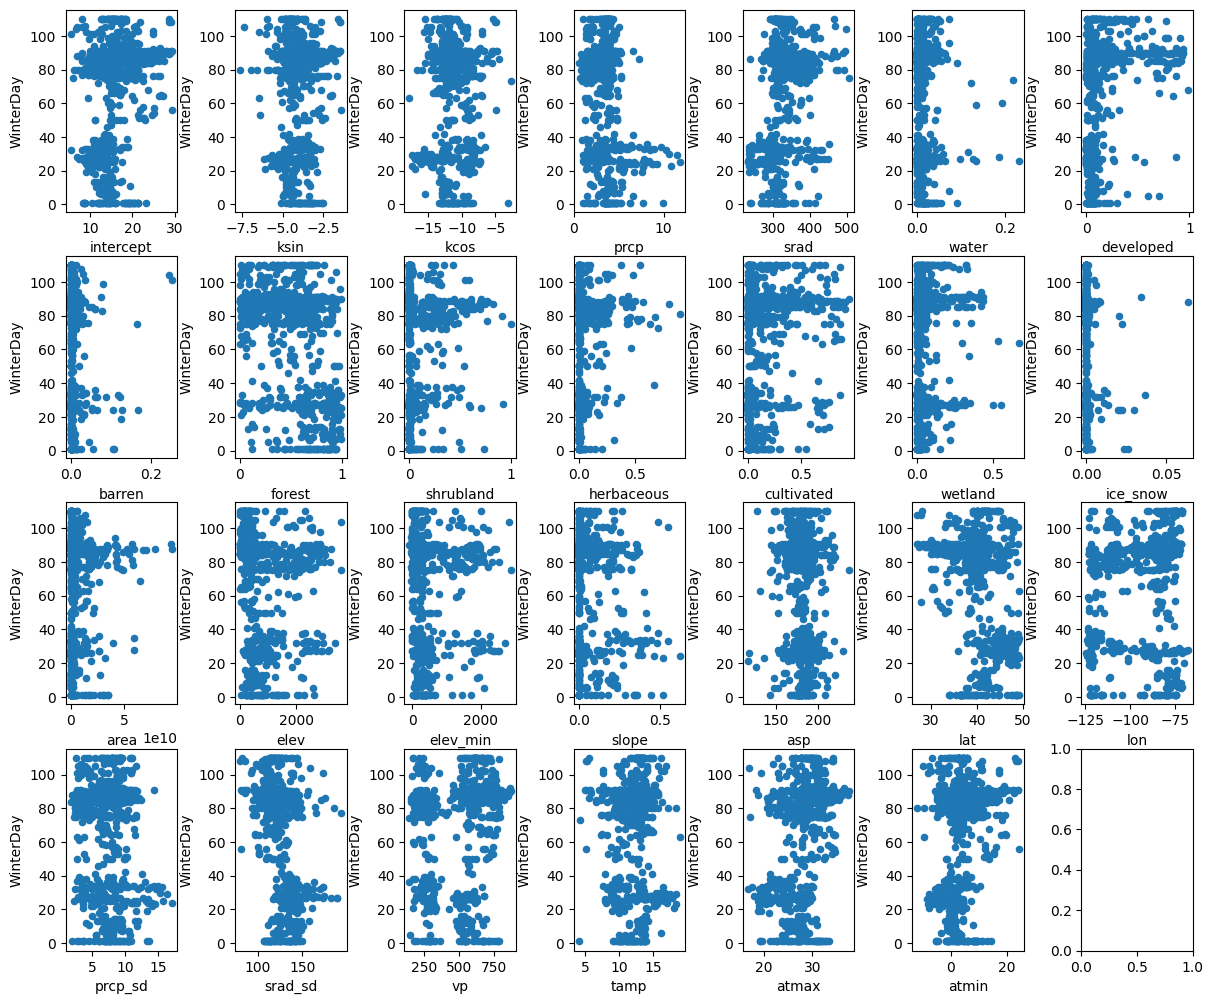

In [81]:
scatterplots("WinterDay")

## Max Sensitivity

TODO here and following:

- Change fitting to report regular coefficient if no cutoff found, etc
- Include Intercept in fitting

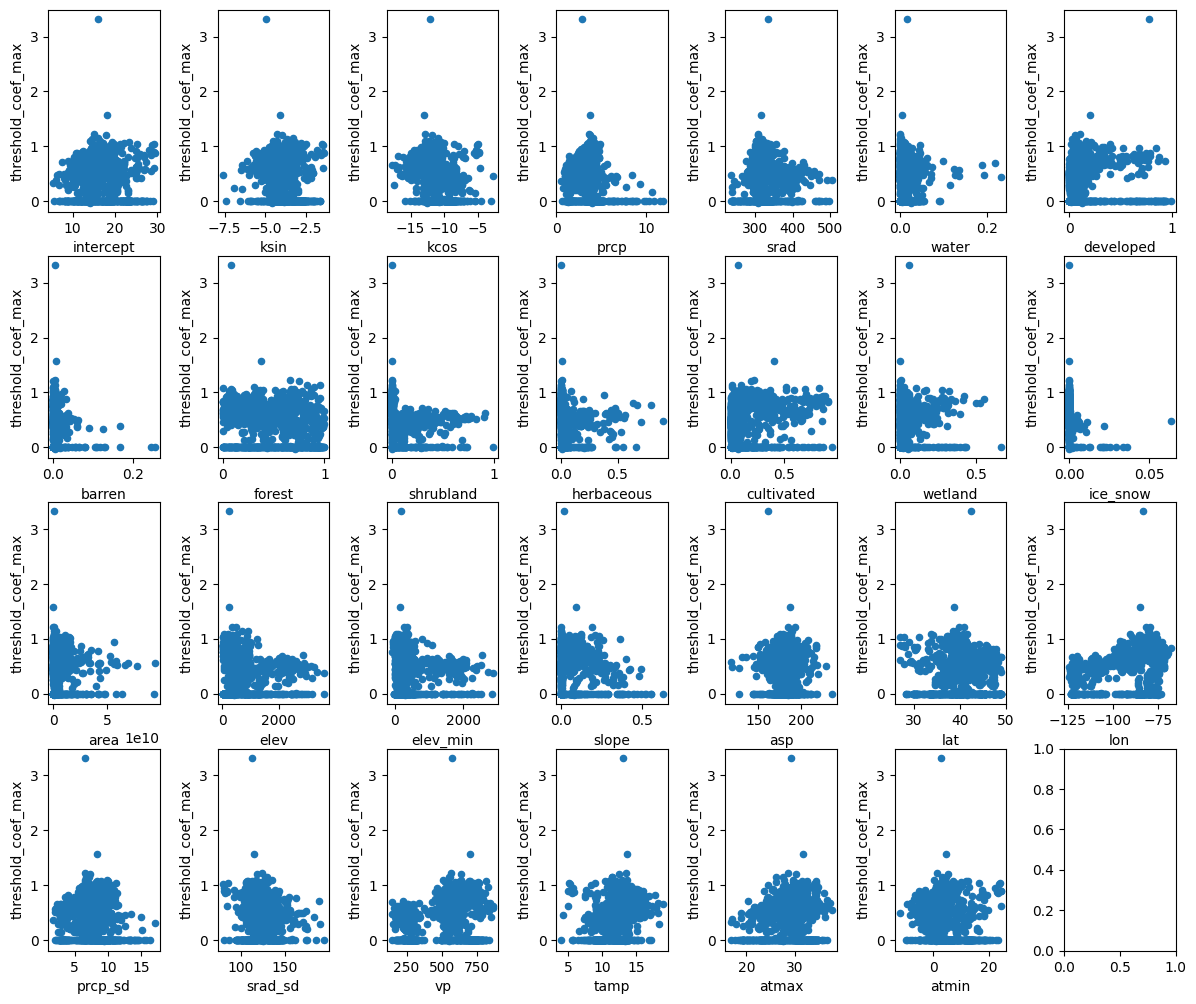

In [83]:
scatterplots("threshold_coef_max")

## Min Sensitivity

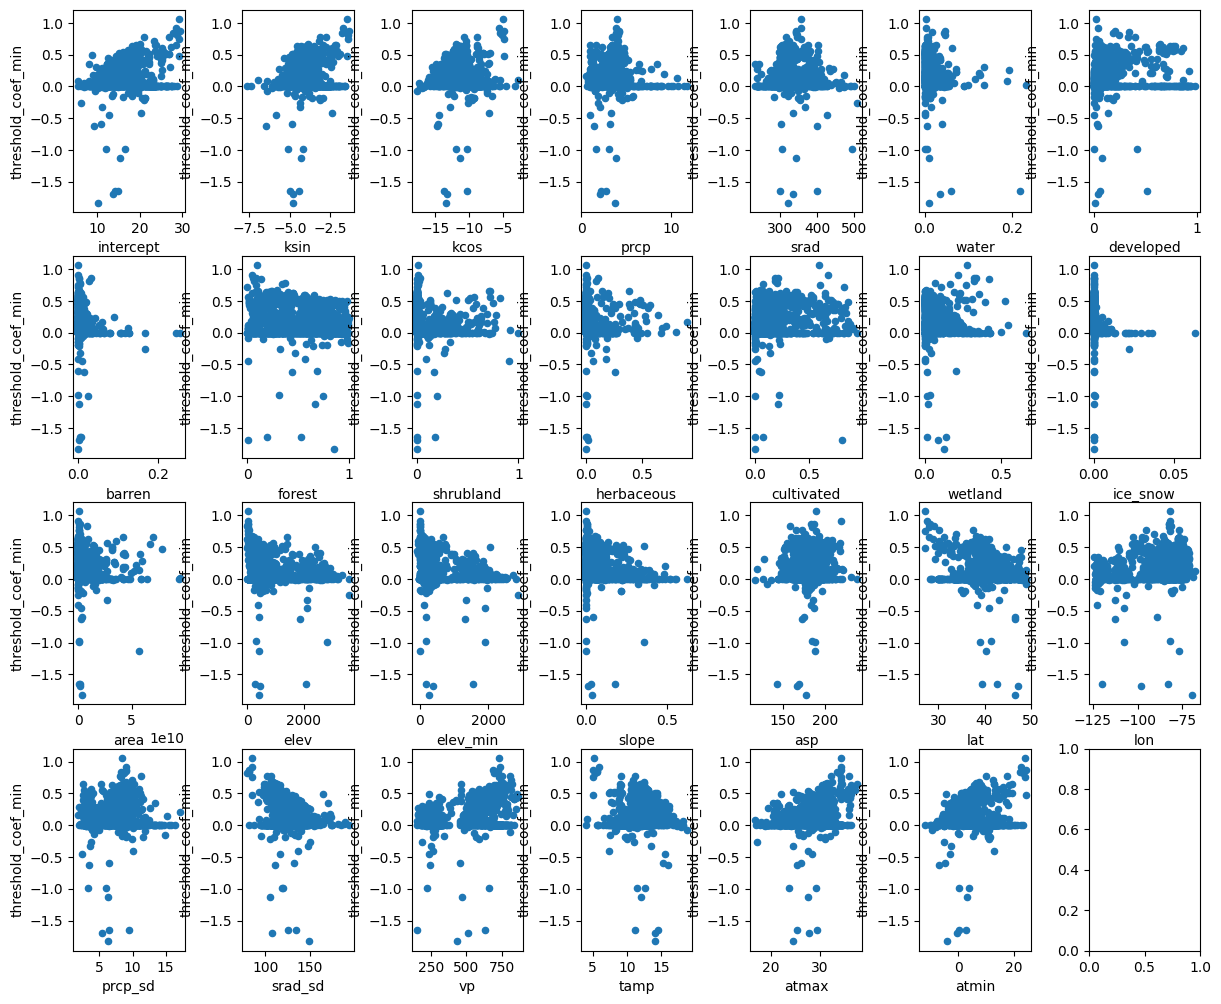

In [84]:
scatterplots("threshold_coef_min")

## Sensitivity Cutoff

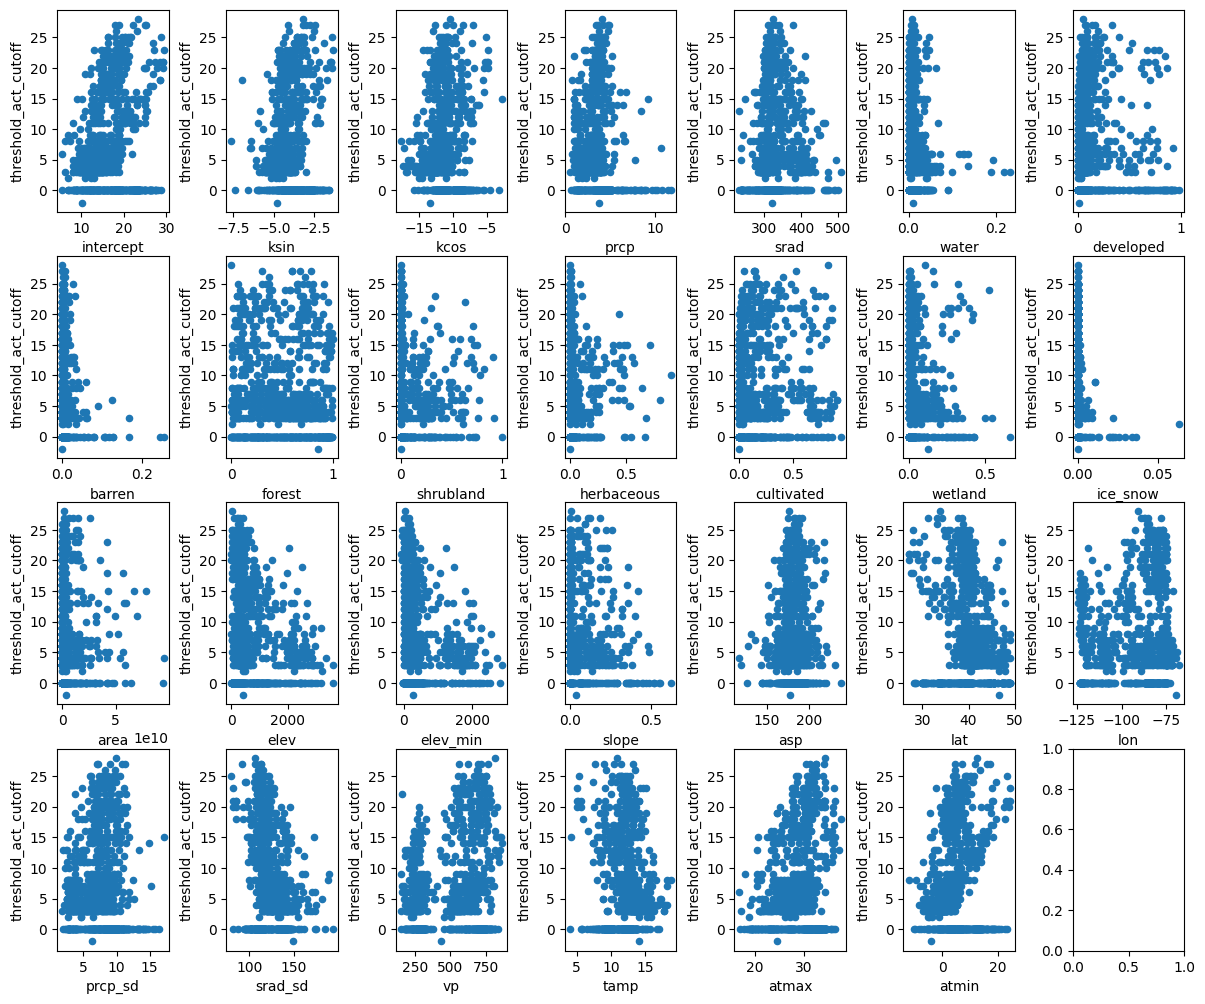

In [86]:
scatterplots("threshold_act_cutoff")

# Cross-Validation Test

Right, we've got some approaches laid out.  Let's test it!  In general, naive GAMs solidly outperform the linear models, so we'll start with those.

## Naive GAMs

In [2]:
itx_var = ["lat", "lon", "tmax_3", "tmax_4", "tmax_12", "vp_2", "vp_11", "vp_12"]
amp_var = ["lat", "lon", "wetland", "kcos_vp", "elev_min"]
ssu_var = ["lat", "lon", "wetland", "prcp_6", "tmax_1", "tmax_2", "tmax_6"]
fw_var = ["lat", "lon", "elev_min", "srad_4", "srad_8", "wetland", "water", "tmax_3"]
spd_var = ["lat", "lon", "prcp_4", "elev_std", "tmax_3", "tmax_4"]
sud_var = ["lat", "lon", "water", "vp_5", "tmax_8", "cultivated", "elev_std", "tmax_9", "tmax_7"]
fad_var = ["lat", "lon", "srad_1", "tmax_12", "tmax_2", "elev", "srad_4", "water"]
wid_var = ["lat", "lon", "srad_10", "prcp_2", "elev_std", "intercept_tm"]
at_var = ["lat", "lon", "area", "water", "forest", "ksin_tm", "vp_2", "vp_3", "vp_12", "intercept_vp", "vp_4"]
vp_var = ["lat", "lon", "srad_10", "vp_5", "ksin_tm", "vp_12", "srad_12", "vp_2", "vp_3", "vp_4", "vp_11", "tmax_12", "tmax_2"]
shared = list(set(itx_var + amp_var + ssu_var + fw_var + spd_var + sud_var + fad_var + wid_var + at_var + vp_var))
names = ["Intercept", "Amplitude", "SpringSummer", "FallWinter", "SpringDay", "SummerDay", "FallDay", "WinterDay", "at_coef", "vp_coef"]

In [3]:
# gam_data = data[["id", "date", "temperature", "vp", "tmax"]].merge(Xmo, on="id")
# gam_data.to_csv("MergedData.csv")
gam_data = pd.read_csv("MergedData.csv", dtype={"id": "str"})
gam_data["date"] = pd.to_datetime(gam_data["date"])
gam_data["day"] = gam_data["date"].dt.day_of_year

In [6]:
cd = gam_data.groupby("id")[shared + names].mean()
g = LinearGAM(build_eq(len(itx_var), True)).fit(cd[itx_var], cd["Intercept"].to_numpy())
g.predict(cd[itx_var])[0]

9.15492775691442

In [13]:
wst = gam_data[gam_data["id"] == gam_data["id"].iloc[0]]
wst[shared].mean().to_frame().T

prcp_6      vp_3   tmax_12     srad_1         lon    tmax_1    tmax_3  \
0  1.063464  275.2133 -4.053537  254.91296 -110.178722 -2.779675  3.363886   

      srad_4     tmax_9     tmax_8  ...  wetland  cultivated     water  \
0  515.61234  16.454326  20.382895  ...  0.04023         0.0  0.000756   

    tmax_2    elev_std        vp_4     tmax_7     tmax_6       vp_11    prcp_2  
0 -3.85792  130.430969  336.044278  21.702253  16.458075  284.830735  3.405588  

[1 rows x 37 columns]

In [17]:
def gam_modbuilder(data):
    print("preparing data")
    cd = data.groupby("id")[shared + names].mean()
    builder = lambda cols, yn: LinearGAM(build_eq(len(cols), True)).fit(cd[cols], cd[yn].to_numpy())
    predictor = lambda cols, gam, ws: gam.predict(ws[cols])[0]
    print("Training models")
    gam_itx = builder(itx_var, "Intercept")
    gam_amp = builder(amp_var, "Amplitude")
    gam_ssu = builder(ssu_var, "SpringSummer")
    gam_fw = builder(fw_var, "FallWinter")
    gam_spd = builder(spd_var, "SpringDay")
    gam_sud = builder(sud_var, "SummerDay")
    gam_fad = builder(fad_var, "FallDay")
    gam_wid = builder(wid_var, "WinterDay")
    gam_at = builder(at_var, "at_coef")
    gam_vp = builder(vp_var, "vp_coef")
    print("Trained models")
    def runner(ws):
        # print(f"Running {ws['id'].iloc[0]}")
        # try:
        at_day = ws.groupby(["day"], as_index=False)["tmax"].mean().rename(columns={"tmax": "mean_tmax"})
        vp_day = ws.groupby(["day"], as_index=False)["vp"].mean().rename(columns={"vp": "mean_vp"})
        statics = ws[shared].mean().to_frame().T
        model = Watershed(seasonality=rts.ThreeSine(
            Intercept=predictor(itx_var, gam_itx, statics),
            Amplitude=predictor(amp_var, gam_amp, statics),
            SpringSummer=predictor(ssu_var, gam_ssu, statics),
            FallWinter=predictor(fw_var, gam_fw, statics),
            SpringDay=predictor(spd_var, gam_spd, statics),
            SummerDay=predictor(sud_var, gam_sud, statics),
            FallDay=predictor(fad_var, gam_fad, statics),
            WinterDay=predictor(wid_var, gam_wid, statics)
        ),
                          at_coef=predictor(at_var, gam_at, statics),
                          vp_coef=predictor(vp_var, gam_vp, statics),
                          at_day=at_day,
                          vp_day=vp_day)
        return model.run_series(ws)
        # except Exception as e:
        #     print(e)
    return runner

In [18]:
kfr = kfold(gam_data, gam_modbuilder, output="results/NaiveGAM.csv")

preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models


/home/jovyan/.local/lib/python3.11/site-packages/rtseason/seasons.py:18: RuntimeWarning: divide by zero encountered in divide
  return np.sin(((days - start) % 365) * 2 * np.pi / len(domain)) * \
/home/jovyan/.local/lib/python3.11/site-packages/rtseason/seasons.py:18: RuntimeWarning: invalid value encountered in sin
  return np.sin(((days - start) % 365) * 2 * np.pi / len(domain)) * \
/home/jovyan/.local/lib/python3.11/site-packages/rtseason/seasons.py:18: RuntimeWarning: divide by zero encountered in divide
  return np.sin(((days - start) % 365) * 2 * np.pi / len(domain)) * \
/home/jovyan/.local/lib/python3.11/site-packages/rtseason/seasons.py:18: RuntimeWarning: invalid value encountered in sin
  return np.sin(((days - start) % 365) * 2 * np.pi / len(domain)) * \


preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models


In [20]:
perf_summary(kfr)

R2      RMSE       NSE     Pbias      Bias   MaxMiss
0  0.694139  4.719429  0.692002  2.082688  0.268983  5.390829

In [22]:
kfr.groupby("id").apply(perf_summary, include_groups=False).median()

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


R2         0.944026
RMSE       2.218157
NSE        0.893316
Pbias      2.413418
Bias       0.308628
MaxMiss    2.774715
dtype: float64

In [34]:
rng = np.random.default_rng()
ids = rng.choice(kfr["id"].unique(), 8)

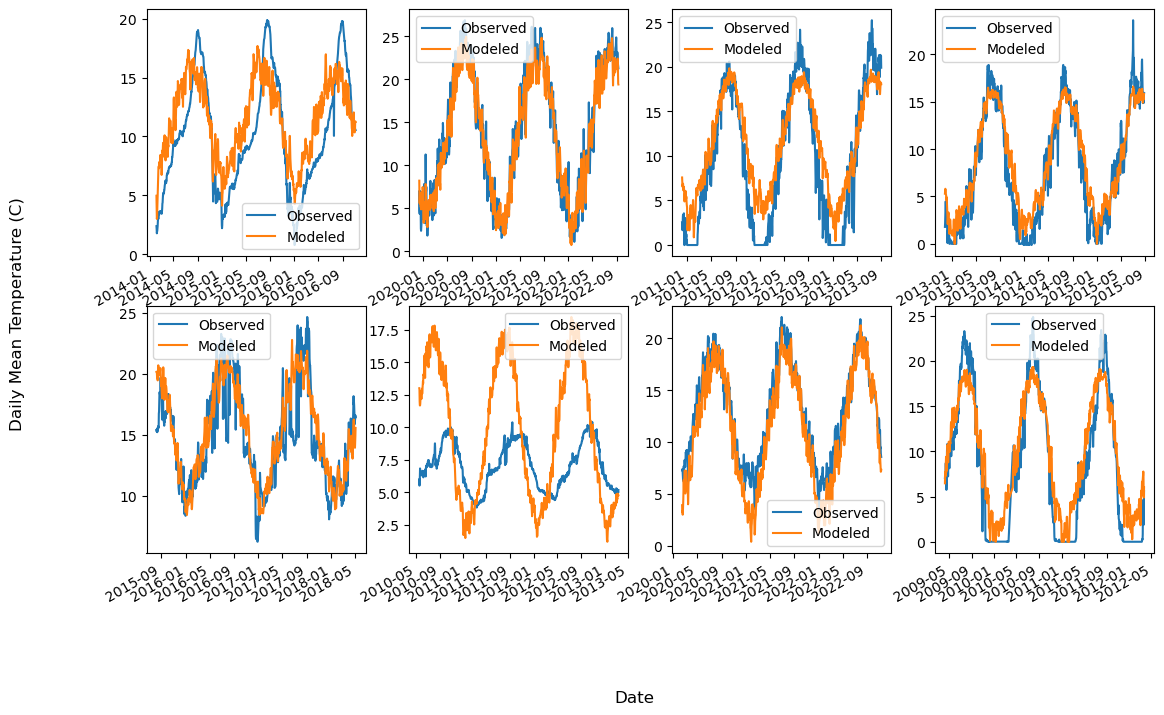

In [39]:
Ny = 2
Nx = 4
fig, axes = plt.subplots(Ny, Nx, figsize=(13, 8))
for i, ID in enumerate(ids):
    ax = axes[i // Nx, i % Nx]
    dat = kfr[kfr["id"] == ID]
    if len(dat) > 1100:
        start = rng.integers(0, len(dat) - 1000)
        dat = dat.iloc[start:(start + 1000), :]
    dat.plot(x="date", y="temperature", label="Observed", ax=ax)
    dat.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.supxlabel("Date")
_ = fig.supylabel("Daily Mean Temperature (C)")

plt.savefig("results/NaiveGAMSample.png", dpi=1000)